# SSD

# Part 1

## training with VOC

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from utils.data_augmentation import ImageGenerator
from utils.train import MultiboxLoss
from utils.train import scheduler
from utils.train import split_data
from models.ssd import SSD300
from utils.boxes import create_prior_boxes
from utils.datasets import DataManager
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, \
                            classification_report, precision_recall_curve, average_precision_score

# parameters
batch_size = 8
num_epochs = 15
num_classes = 21
optimizer = Adam(lr=3e-4)
root_prefix = '../datasets/VOCdevkit/VOC2007/'
ground_data_prefix = root_prefix + 'Annotations/'
image_prefix = root_prefix + 'JPEGImages/'
image_shape = (300, 300 ,3)
dataset_name = 'VOC2007'
weights_path = '../trained_models/weights_SSD300.hdf5'
trained_models_path = '../trained_models/model_checkpoints/'
trained_models_filename = (trained_models_path +
                        'ssd300_weights.{epoch:03d}-{val_loss:.3f}.hdf5')
frozen_layers = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
                'conv2_1', 'conv2_2', 'pool2',
                'conv3_1', 'conv3_2', 'conv3_3', 'pool3']
box_scale_factors = [.1, .1, .2, .2]



#voc_classes = ['car','truck','biker','pedestrian','traficlight']
#voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               #'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               #'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               #'Sheep', 'Sofa', 'Train', 'Tvmonitor']



In [ ]:
import glob
import os
from xml.etree import ElementTree

import numpy as np
try:
    from pycocotools.coco import COCO
except ImportError:
    COCO = None

class XMLParser(object):
    """ Preprocess the VOC2007 xml annotations data.

    # TODO: Add background label

    # Arguments
        data_path: Data path to VOC2007 annotations

    # Return
        data: Dictionary which keys correspond to the image names
        and values are numpy arrays of shape (num_objects, 4 + num_classes)
        num_objects refers to the number of objects in that specific image
    """

    def __init__(self, data_path, class_names=None, dataset_name='VOC2007'):
        self.path_prefix = data_path
        self.dataset_name = dataset_name
        self.class_names = class_names
        if self.class_names == None:
            self.class_names = get_class_names(self.dataset_name)
        self.num_classes = len(self.class_names)
        keys = np.arange(self.num_classes)
        self.arg_to_class = dict(zip(keys, self.class_names))
        self.class_to_arg = {value: key for key, value
                             in self.arg_to_class.items()}
        self.data = dict()
        self.difficult_objects = dict()
        self._preprocess_XML()

    def get_data(self):
        return self.data

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:
            tree = ElementTree.parse(self.path_prefix + filename)
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            difficulties = []
            size_tree = root.find('size')
            width = float(size_tree.find('width').text)
            height = float(size_tree.find('height').text)
            for object_tree in root.findall('object'):
                difficulty = int(object_tree.find('difficult').text)
                class_name = object_tree.find('name').text
                if class_name in self.class_names:
                    one_hot_class = self._to_one_hot(class_name)
                    one_hot_classes.append(one_hot_class)
                    for bounding_box in object_tree.iter('bndbox'):
                        xmin = float(bounding_box.find('xmin').text) / width
                        ymin = float(bounding_box.find('ymin').text) / height
                        xmax = float(bounding_box.find('xmax').text) / width
                        ymax = float(bounding_box.find('ymax').text) / height
                    bounding_box = [xmin, ymin, xmax, ymax]
                    bounding_boxes.append(bounding_box)
                    difficulties.append(difficulty)
            if len(one_hot_classes) == 0:
                continue
            image_name = root.find('filename').text
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            if len(bounding_boxes.shape) == 1:
                image_data = np.expand_dims(image_data, axis=0)
            self.data[image_name] = image_data
            self.difficult_objects[image_name] = difficulties

    def _to_one_hot(self, class_name):
        one_hot_vector = [0] * self.num_classes
        class_arg = self.class_to_arg[class_name]
        one_hot_vector[class_arg] = 1
        return one_hot_vector

class COCOParser(object):
    def __init__(self, annotations_path, class_names='all'):
        self.coco = COCO(annotations_path)
        self.class_names = class_names
        if self.class_names == 'all':
            class_data = self.coco.loadCats(self.coco.getCatIds())
            self.class_names = [class_['name'] for class_ in class_data]
            coco_ids = [class_['id'] for class_ in class_data]
            one_hot_ids = list(range(1, len(coco_ids) + 1))
            self.coco_id_to_class_arg = dict(zip(coco_ids, one_hot_ids))
            self.class_names = ['background'] + self.class_names
            self.num_classes = len(self.class_names)
        elif len(self.class_names) > 1:
            raise NotImplementedError('Only one or all classes supported')
        self.data = dict()

    def get_data(self):
        self._get_data()
        return self.data

    def _get_data(self):
        image_ids = self.coco.getImgIds()
        for image_id in image_ids:
            image_data = self.coco.loadImgs(image_id)[0]
            image_file_name = image_data['file_name']
            width = float(image_data['width'])
            height = float(image_data['height'])
            annotation_ids = self.coco.getAnnIds(imgIds=image_data['id'])
            annotations = self.coco.loadAnns(annotation_ids)
            num_objects_in_image = len(annotations)
            if num_objects_in_image == 0:
                continue
            image_ground_truth = []
            for object_arg in range(num_objects_in_image):
                coco_id = annotations[object_arg]['category_id']
                class_arg = self.coco_id_to_class_arg[coco_id]
                one_hot_class = self._to_one_hot(class_arg)
                coco_coordinates = annotations[object_arg]['bbox']
                #print('coco_coordinates:', coco_coordinates)
                x_min = (coco_coordinates[0]) #/ width
                y_min = (coco_coordinates[1]) #/ height
                x_max = (x_min + coco_coordinates[2]) #/ width
                y_max = (y_min + coco_coordinates[3]) #/ height
                #print('transformed_coordinates:', [x_min, y_min, x_max, y_max])
                x_min = x_min / width
                y_min = y_min / height
                x_max = x_max / width
                y_max = y_max / height
                #print('normalized_coordinates:', [x_min, y_min, x_max, y_max])
                ground_truth = [x_min, y_min, x_max, y_max] + one_hot_class
                image_ground_truth.append(ground_truth)
            image_ground_truth = np.asarray(image_ground_truth)
            if len(image_ground_truth.shape) == 1:
                image_ground_truth = np.expand_dims(image_ground_truth, 0)
            self.data[image_file_name] = image_ground_truth

    def _to_one_hot(self, class_arg):
        one_hot_vector = [0] * self.num_classes
        one_hot_vector[class_arg] = 1
        return one_hot_vector


class DataManager(object):
    """Class for loading VOC2007 and COCO datasets or
    """
    def __init__(self, dataset_name='VOC2007', class_names=None,
                                    dataset_path_prefix=None,
                                    image_prefix=None):

        self.dataset_name = dataset_name
        self.dataset_path_prefix = dataset_path_prefix
        self.image_prefix = image_prefix
        self.class_names = class_names
        self.ground_truth_data = None
        self.parser = None
        if self.dataset_path_prefix == None:
            self.dataset_path_prefix = '../datasets/VOCdevkit/VOC2007/Annotations/'
        else:
            self.dataset_path_prefix = dataset_path_prefix

        if self.image_prefix == None:
            self.image_prefix = '../datasets/VOCdevkit/VOC2007/JPEGImages/'
        else:
            self.image_prefix = image_prefix

        if self.dataset_name == 'VOC2007':
            self._load_VOC2007()
        elif self.dataset_name == 'COCO':
            self.dataset_path_prefix = ('../datasets/COCO/annotations/' +
                                                'instances_train2014.json')
            self._load_COCO()
        elif self.dataset_name == 'all':
            raise NotImplementedError
        else:
            raise Exception('Incorrect dataset name:', self.dataset_name)

    def get_data(self):
        print('Deprecated function use function: load_data instead')
        return self.ground_truth_data

    def load_data(self):
        return self.ground_truth_data

    def _load_VOC2007(self):
        self.parser = XMLParser(self.dataset_path_prefix, self.class_names)
        self.ground_truth_data = self.parser.get_data()
        self.class_names = self.parser.class_names
        self.arg_to_class = self.parser.arg_to_class
        self.class_to_arg = self.parser.class_to_arg

    def _load_COCO(self):
        self.parser = COCOParser(self.dataset_path_prefix)
        self.ground_truth_data = self.parser.get_data()

def get_class_names(dataset_name='VOC2007'):
    if dataset_name == 'VOC2007':
        class_names = ['background','aeroplane', 'bicycle', 'bird', 'boat',
                       'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                       'diningtable', 'dog', 'horse', 'motorbike', 'person',
                       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    elif dataset_name == 'COCO':
        class_names = ['background', 'person', 'bicycle', 'car', 'motorcycle',
                        'airplane', 'bus', 'train', 'truck', 'boat',
                        'traffic light', 'fire hydrant', 'stop sign',
                        'parking meter', 'bench', 'bird', 'cat', 'dog',
                        'horse', 'sheep', 'cow', 'elephant', 'bear',
                        'zebra', 'giraffe', 'backpack', 'umbrella',
                        'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
                        'snowboard', 'sports ball', 'kite', 'baseball bat',
                        'baseball glove', 'skateboard', 'surfboard',
                        'tennis racket', 'bottle', 'wine glass',
                        'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                        'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                        'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                        'potted plant', 'bed', 'dining table', 'toilet',
                        'tv', 'laptop', 'mouse', 'remote', 'keyboard',
                        'cell phone', 'microwave', 'oven', 'toaster',
                        'sink', 'refrigerator', 'book', 'clock', 'vase',
                        'scissors', 'teddy bear', 'hair drier', 'toothbrush']
    else:
        raise Exception('Invalid dataset', dataset_name)
    return class_names

def get_arg_to_class(class_names):
    return dict(zip(list(range(len(class_names))), class_names))

def list_files_in_directory(path_name='*'):
    return glob.glob(path_name)


In [ ]:
import tensorflow as tf
import keras.backend as K

class MultiboxLoss(object):
    
    
    def __init__(self, num_classes, alpha=1.0, neg_pos_ratio=3.0,
                 background_id=0, negatives_for_hard=100.0):
        self.num_classes = num_classes
        self.alpha = alpha
        self.neg_pos_ratio = neg_pos_ratio
        self.background_id = background_id
        self.negatives_for_hard = negatives_for_hard
        
        '''Multibox loss with some helper functions.
        # Arguments
        num_classes: Number of classes including background.
        alpha: Weight of L1-smooth loss.
        neg_pos_ratio: Max ratio of negative to positive boxes in loss.
        background_label_id: Id of background label.
        negatives_for_hard: Number of negative boxes to consider
            it there is no positive boxes in batch.
        # References
        https://arxiv.org/abs/1512.02325'''
        

    def _l1_smooth_loss(self, y_true, y_pred):
        
        """Compute L1-smooth loss.
        # Arguments
            y_true: Ground truth bounding boxes,
                tensor of shape (?, num_boxes, 4).
            y_pred: Predicted bounding boxes,
                tensor of shape (?, num_boxes, 4).
        # Returns
            l1_loss: L1-smooth loss, tensor of shape (?, num_boxes).
        # References
            https://arxiv.org/abs/1504.08083
        """
        absolute_value_loss = tf.abs(y_true - y_pred) - 0.5
        square_loss = 0.5 * (y_true - y_pred)**2
        absolute_value_condition = K.less(absolute_value_loss, 1.0)
        l1_smooth_loss = tf.where(absolute_value_condition, square_loss,
                                                    absolute_value_loss)
        return K.sum(l1_smooth_loss, axis=-1)

    def _softmax_loss(self, y_true, y_pred):
        
        """Compute softmax loss.
        # Arguments
            y_true: Ground truth targets,
                tensor of shape (?, num_boxes, num_classes).
            y_pred: Predicted logits,
                tensor of shape (?, num_boxes, num_classes).
        # Returns
            softmax_loss: Softmax loss, tensor of shape (?, num_boxes).
        """
        y_pred = K.maximum(K.minimum(y_pred, 1 - 1e-15), 1e-15)
        softmax_loss = - K.sum(y_true * K.log(y_pred), axis=-1)
        return softmax_loss

    def compute_loss(self, y_true, y_pred):
        """Compute mutlibox loss.
        # Arguments
            y_true: Ground truth targets,
                tensor of shape (?, num_boxes, 4 + num_classes + 8),
                priors in ground truth are fictitious,
                y_true[:, :, -8] has 1 if prior should be penalized
                    or in other words is assigned to some ground truth box,
                y_true[:, :, -7:] are all 0.
            y_pred: Predicted logits,
                tensor of shape (?, num_boxes, 4 + num_classes + 8).
        # Returns
            loss: Loss for prediction, tensor of shape (?,).
        """
        batch_size = K.shape(y_true)[0]
        num_prior_boxes = K.cast(K.shape(y_true)[1], 'float')

        y_pred_localization = y_pred[:, :, :4]
        y_true_localization = y_true[:, :, :4]
        y_pred_classification = y_pred[:, :, 4:(4 + self.num_classes)]
        y_true_classification = y_true[:, :, 4:(4 + self.num_classes)]

        localization_loss = self._l1_smooth_loss(y_true_localization,
                                                 y_pred_localization)
        classification_loss = self._softmax_loss(y_true_classification,
                                                 y_pred_classification)

        int_positive_mask = 1 - y_true[:, :, 4 + self.background_id]
        num_positives = tf.reduce_sum(int_positive_mask, axis=-1)
        positive_localization_losses = (localization_loss * int_positive_mask)
        positive_classification_losses = (classification_loss *
                                          int_positive_mask)
        positive_classification_loss = K.sum(positive_classification_losses, 1)
        positive_localization_loss = K.sum(positive_localization_losses, 1)

        num_negatives_1 = self.neg_pos_ratio * num_positives
        num_negatives_2 = num_prior_boxes - num_positives
        num_negatives = tf.minimum(num_negatives_1, num_negatives_2)

        num_positive_mask = tf.greater(num_negatives, 0)
        has_a_positive = tf.to_float(tf.reduce_any(num_positive_mask))
        num_negatives = tf.concat([num_negatives,
                        [(1 - has_a_positive) * self.negatives_for_hard]], 0)
        num_positive_mask = tf.greater(num_negatives, 0)
        num_neg_batch = tf.reduce_min(tf.boolean_mask(num_negatives,
                                                num_positive_mask))
        num_neg_batch = tf.to_int32(num_neg_batch)

        pred_class_values = K.max(y_pred_classification[:, :, 1:], axis=2)
        int_negatives_mask = y_true[:, :, 4 + self.background_id]
        pred_negative_class_values = pred_class_values * int_negatives_mask
        top_k_negative_indices = tf.nn.top_k(pred_negative_class_values,
                                                    k=num_neg_batch)[1]

        batch_indices = K.expand_dims(K.arange(0, batch_size), 1)
        batch_indices = K.tile(batch_indices, (1, num_neg_batch))
        batch_indices = K.flatten(batch_indices) * K.cast(num_prior_boxes,
                                                                'int32')
        full_indices = batch_indices + K.flatten(top_k_negative_indices)

        negative_classification_loss = K.gather(K.flatten(classification_loss),
                                                                full_indices)
        negative_classification_loss = K.reshape(negative_classification_loss,
                                                    [batch_size, num_neg_batch])
        negative_classification_loss = K.sum(negative_classification_loss, 1)

        # loss is sum of positives and negatives
        total_loss = (positive_classification_loss +
                      negative_classification_loss)
        num_prior_boxes_per_batch = (num_positives +
                                     K.cast(num_neg_batch, 'float'))
        total_loss = total_loss / num_prior_boxes_per_batch
        num_positives = tf.where(K.not_equal(num_positives, 0), num_positives,
                                                   K.ones_like(num_positives))
        positive_localization_loss = self.alpha * positive_classification_loss
        positive_localization_loss = positive_localization_loss / num_positives
        total_loss = total_loss + positive_localization_loss
        return total_loss

def scheduler(epoch, decay=0.9, base_learning_rate=3e-4):
    return base_learning_rate * decay**(epoch)

def split_data(ground_truths, training_ratio=.8):
    ground_truth_keys = sorted(ground_truths.keys())
    num_train = int(round(training_ratio * len(ground_truth_keys)))
    train_keys = ground_truth_keys[:num_train]
    validation_keys = ground_truth_keys[num_train:]
    return train_keys, validation_keys


In [ ]:
# loading and splitting data
data_manager = DataManager(dataset_name)

ground_truth_data = data_manager.load_data()

 

train_keys, validation_keys = split_data(ground_truth_data, training_ratio=.8)

print('ground_truth_data sample',ground_truth_data )
print('train_keys', len(train_keys))
print('validation_keys', len(validation_keys))

In [ ]:
import numpy as np
import keras.backend as K
from keras.engine.topology import InputSpec
from keras.engine.topology import Layer

class Normalize(Layer):
    """Normalization layer as described in ParseNet paper.

    # Arguments
        scale: Default feature scale.

    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.

    # Output shape
        Same as input

    # References
        http://cs.unc.edu/~wliu/papers/parsenet.pdf

    #TODO
        Add possibility to have one scale for all features.
    """
    def __init__(self, scale, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.axis = 3
        else:
            self.axis = 1
        self.scale = scale
        super(Normalize, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)
        init_gamma = self.scale * np.ones(shape)
        self.gamma = K.variable(init_gamma, name='{}_gamma'.format(self.name))
        self.trainable_weights = [self.gamma]

    def call(self, x, mask=None):
        output = K.l2_normalize(x, self.axis)
        output *= self.gamma
        return output


class PriorBox(Layer):
    """Generate the prior boxes of designated sizes and aspect ratios.

    # Arguments
        img_size: Size of the input image as tuple (w, h).
        min_size: Minimum box size in pixels.
        max_size: Maximum box size in pixels.
        aspect_ratios: List of aspect ratios of boxes.
        flip: Whether to consider reverse aspect ratios.
        variances: List of variances for x, y, w, h.
        clip: Whether to clip the prior's coordinates
            such that they are within [0, 1].

    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.

    # Output shape
        3D tensor with shape:
        (samples, num_boxes, 8)

    # References
        https://arxiv.org/abs/1512.02325

    #TODO
        Add possibility not to have variances.
        Add Theano support
    """
    def __init__(self, img_size, min_size, max_size=None, aspect_ratios=None,
                 flip=True, variances=[0.1], clip=True, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.waxis = 2
            self.haxis = 1
        else:
            self.waxis = 3
            self.haxis = 2
        self.img_size = img_size
        if min_size <= 0:
            raise Exception('min_size must be positive.')
        self.min_size = min_size
        self.max_size = max_size
        self.aspect_ratios = [1.0]
        if max_size:
            if max_size < min_size:
                raise Exception('max_size must be greater than min_size.')
            self.aspect_ratios.append(1.0)
        if aspect_ratios:
            for ar in aspect_ratios:
                if ar in self.aspect_ratios:
                    continue
                self.aspect_ratios.append(ar)
                if flip:
                    self.aspect_ratios.append(1.0 / ar)
        self.variances = np.array(variances)
        self.clip = True
        super(PriorBox, self).__init__(**kwargs)

    def get_output_shape_for(self, input_shape):
        num_priors_ = len(self.aspect_ratios)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        num_boxes = num_priors_ * layer_width * layer_height
        return input_shape[0], num_boxes, 8

    # support for Keras 2.0
    def compute_output_shape(self, input_shape):
        return self.get_output_shape_for(input_shape)

    def call(self, x, mask=None):
        if hasattr(x, '_keras_shape'):
            input_shape = x._keras_shape
        elif hasattr(K, 'int_shape'):
            input_shape = K.int_shape(x)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        img_width = self.img_size[0]
        img_height = self.img_size[1]
        # define prior boxes shapes
        box_widths = []
        box_heights = []
        for ar in self.aspect_ratios:
            if ar == 1 and len(box_widths) == 0:
                box_widths.append(self.min_size)
                box_heights.append(self.min_size)
            elif ar == 1 and len(box_widths) > 0:
                box_widths.append(np.sqrt(self.min_size * self.max_size))
                box_heights.append(np.sqrt(self.min_size * self.max_size))
            elif ar != 1:
                box_widths.append(self.min_size * np.sqrt(ar))
                box_heights.append(self.min_size / np.sqrt(ar))
        box_widths = 0.5 * np.array(box_widths)
        box_heights = 0.5 * np.array(box_heights)
        # define centers of prior boxes
        step_x = img_width / layer_width
        step_y = img_height / layer_height
        linx = np.linspace(0.5 * step_x, img_width - 0.5 * step_x,
                           layer_width)
        liny = np.linspace(0.5 * step_y, img_height - 0.5 * step_y,
                           layer_height)
        centers_x, centers_y = np.meshgrid(linx, liny)
        centers_x = centers_x.reshape(-1, 1)
        centers_y = centers_y.reshape(-1, 1)
        # define xmin, ymin, xmax, ymax of prior boxes
        num_priors_ = len(self.aspect_ratios)
        prior_boxes = np.concatenate((centers_x, centers_y), axis=1)
        prior_boxes = np.tile(prior_boxes, (1, 2 * num_priors_))
        prior_boxes[:, ::4] -= box_widths
        prior_boxes[:, 1::4] -= box_heights
        prior_boxes[:, 2::4] += box_widths
        prior_boxes[:, 3::4] += box_heights
        prior_boxes[:, ::2] /= img_width
        prior_boxes[:, 1::2] /= img_height
        prior_boxes = prior_boxes.reshape(-1, 4)
        if self.clip:
            prior_boxes = np.minimum(np.maximum(prior_boxes, 0.0), 1.0)
        # define variances
        num_boxes = len(prior_boxes)
        if len(self.variances) == 1:
            variances = np.ones((num_boxes, 4)) * self.variances[0]
        elif len(self.variances) == 4:
            variances = np.tile(self.variances, (num_boxes, 1))
        else:
            raise Exception('Must provide one or four variances.')
        prior_boxes = np.concatenate((prior_boxes, variances), axis=1)
        prior_boxes_tensor = K.expand_dims(K.variable(prior_boxes), 0)
        pattern = [K.shape(x)[0], 1, 1]
        prior_boxes_tensor = K.tile(prior_boxes_tensor, pattern)
        return prior_boxes_tensor


        """
        if K.backend() == 'tensorflow':
            pattern = [tf.shape(x)[0], 1, 1]
            prior_boxes_tensor = tf.tile(prior_boxes_tensor, pattern)
        elif K.backend() == 'theano':
            #TODO
            pass
        return prior_boxes_tensor
        """


In [ ]:
import keras.backend as K
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.layers import concatenate
from keras.models import Model

#from .layers import Normalize
#from .layers import PriorBox


def SSD300(input_shape=(300, 300, 3), num_classes=21, weights_path=None,
                                                    frozen_layers=None):
    """SSD300 architecture.

    # Arguments
        input_shape: Shape of the input image,
            expected to be either (300, 300, 3) or (3, 300, 300)(not tested).
        num_classes: Number of classes including background.

    # References
        https://arxiv.org/abs/1512.02325
    """
    input_layer = Input(shape=input_shape)

    # Block 1
    conv1_1 = Conv2D(64, (3, 3),
                     name='conv1_1',
                     padding='same',
                     activation='relu')(input_layer)

    conv1_2 = Conv2D(64, (3, 3),
                     name='conv1_2',
                     padding='same',
                     activation='relu')(conv1_1)
    pool1 = MaxPooling2D(name='pool1',
                         pool_size=(2, 2),
                         strides=(2, 2),
                         padding='same', )(conv1_2)

    # Block 2
    conv2_1 = Conv2D(128, (3, 3),
                     name='conv2_1',
                     padding='same',
                     activation='relu')(pool1)
    conv2_2 = Conv2D(128, (3, 3),
                     name='conv2_2',
                     padding='same',
                     activation='relu')(conv2_1)
    pool2 = MaxPooling2D(name='pool2',
                         pool_size=(2, 2),
                         strides=(2, 2),
                         padding='same')(conv2_2)

    # Block 3
    conv3_1 = Conv2D(256, (3, 3),
                     name='conv3_1',
                     padding='same',
                     activation='relu')(pool2)
    conv3_2 = Conv2D(256, (3, 3),
                     name='conv3_2',
                     padding='same',
                     activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, (3, 3),
                     name='conv3_3',
                     padding='same',
                     activation='relu')(conv3_2)
    pool3 = MaxPooling2D(name='pool3',
                         pool_size=(2, 2),
                         strides=(2, 2),
                         padding='same')(conv3_3)

    # Block 4
    conv4_1 = Conv2D(512, (3, 3),
                     name='conv4_1',
                     padding='same',
                     activation='relu')(pool3)
    conv4_2 = Conv2D(512, (3, 3),
                     name='conv4_2',
                     padding='same',
                     activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, (3, 3),
                     name='conv4_3',
                     padding='same',
                     activation='relu')(conv4_2)
    pool4 = MaxPooling2D(name='pool4',
                         pool_size=(2, 2),
                         strides=(2, 2),
                         padding='same')(conv4_3)

    # Block 5
    conv5_1 = Conv2D(512, (3, 3),
                     name='conv5_1',
                     padding='same',
                     activation='relu')(pool4)
    conv5_2 = Conv2D(512, (3, 3),
                     name='conv5_2',
                     padding='same',
                     activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, (3, 3),
                     name='conv5_3',
                     padding='same',
                     activation='relu')(conv5_2)
    pool5 = MaxPooling2D(name='pool5',
                         pool_size=(3, 3),
                         strides=(1, 1),
                         padding='same')(conv5_3)

    # FC6
    fc6 = Conv2D(1024, (3, 3),
                 name='fc6',
                 dilation_rate=(6, 6),
                 padding='same',
                 activation='relu'
                 )(pool5)

    # x = Dropout(0.5, name='drop6')(x)
    # FC7
    fc7 = Conv2D(1024, (1, 1),
                 name='fc7',
                 padding='same',
                 activation='relu'
                 )(fc6)
    # x = Dropout(0.5, name='drop7')(x)

    # Block 6
    conv6_1 = Conv2D(256, (1, 1),
                     name='conv6_1',
                     padding='same',
                     activation='relu')(fc7)
    conv6_2 = Conv2D(512, (3, 3),
                     name='conv6_2',
                     strides=(2, 2),
                     padding='same',
                     activation='relu')(conv6_1)

    # Block 7
    conv7_1 = Conv2D(128, (1, 1),
                     name='conv7_1',
                     padding='same',
                     activation='relu')(conv6_2)
    conv7_1z = ZeroPadding2D(name='conv7_1z')(conv7_1)
    conv7_2 = Conv2D(256, (3, 3),
                     name='conv7_2',
                     padding='valid',
                     strides=(2, 2),
                     activation='relu')(conv7_1z)

    # Block 8
    conv8_1 = Conv2D(128, (1, 1),
                     name='conv8_1',
                     padding='same',
                     activation='relu')(conv7_2)
    conv8_2 = Conv2D(256, (3, 3),
                     name='conv8_2',
                     padding='same',
                     strides=(2, 2),
                     activation='relu')(conv8_1)

    # Last Pool
    pool6 = GlobalAveragePooling2D(name='pool6')(conv8_2)

    # Prediction from conv4_3
    num_priors = 3
    img_size = (input_shape[1], input_shape[0])
    name = 'conv4_3_norm_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)

    conv4_3_norm = Normalize(20, name='conv4_3_norm')(conv4_3)
    conv4_3_norm_mbox_loc = Conv2D(num_priors * 4, (3, 3),
                                   name='conv4_3_norm_mbox_loc',
                                   padding='same')(conv4_3_norm)
    conv4_3_norm_mbox_loc_flat = Flatten(name='conv4_3_norm_mbox_loc_flat')(conv4_3_norm_mbox_loc)
    conv4_3_norm_mbox_conf = Conv2D(num_priors * num_classes, (3, 3),
                                    name=name,
                                    padding='same')(conv4_3_norm)
    conv4_3_norm_mbox_conf_flat = Flatten(name='conv4_3_norm_mbox_conf_flat')(conv4_3_norm_mbox_conf)
    conv4_3_norm_mbox_priorbox = PriorBox(img_size, 30.0,
                                          name='conv4_3_norm_mbox_priorbox',
                                          aspect_ratios=[2],
                                          variances=[0.1, 0.1, 0.2, 0.2])(conv4_3_norm)

    # Prediction from fc7
    num_priors = 6
    name = 'fc7_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    fc7_mbox_conf = Conv2D(num_priors * num_classes, (3, 3),
                           padding='same',
                           name=name)(fc7)
    fc7_mbox_conf_flat = Flatten(name='fc7_mbox_conf_flat')(fc7_mbox_conf)

    fc7_mbox_loc = Conv2D(num_priors * 4, (3, 3),
                          name='fc7_mbox_loc',
                          padding='same')(fc7)
    fc7_mbox_loc_flat = Flatten(name='fc7_mbox_loc_flat')(fc7_mbox_loc)
    fc7_mbox_priorbox = PriorBox(img_size, 60.0,
                                 name='fc7_mbox_priorbox',
                                 max_size=114.0,
                                 aspect_ratios=[2, 3],
                                 variances=[0.1, 0.1, 0.2, 0.2]
                                 )(fc7)

    # Prediction from conv6_2
    num_priors = 6
    name = 'conv6_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    conv6_2_mbox_conf = Conv2D(num_priors * num_classes, (3, 3),
                               padding='same',
                               name=name)(conv6_2)
    conv6_2_mbox_conf_flat = Flatten(name='conv6_2_mbox_conf_flat')(conv6_2_mbox_conf)
    conv6_2_mbox_loc = Conv2D(num_priors * 4, (3, 3,),
                              name='conv6_2_mbox_loc',
                              padding='same')(conv6_2)
    conv6_2_mbox_loc_flat = Flatten(name='conv6_2_mbox_loc_flat')(conv6_2_mbox_loc)
    conv6_2_mbox_priorbox = PriorBox(img_size, 114.0,
                                     max_size=168.0,
                                     aspect_ratios=[2, 3],
                                     variances=[0.1, 0.1, 0.2, 0.2],
                                     name='conv6_2_mbox_priorbox')(conv6_2)
    # Prediction from conv7_2
    num_priors = 6
    name = 'conv7_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    conv7_2_mbox_conf = Conv2D(num_priors * num_classes, (3, 3),
                               padding='same',
                               name=name)(conv7_2)
    conv7_2_mbox_conf_flat = Flatten(name='conv7_2_mbox_conf_flat')(conv7_2_mbox_conf)
    conv7_2_mbox_loc = Conv2D(num_priors * 4, (3, 3),
                              padding='same',
                              name='conv7_2_mbox_loc')(conv7_2)
    conv7_2_mbox_loc_flat = Flatten(name='conv7_2_mbox_loc_flat')(conv7_2_mbox_loc)
    conv7_2_mbox_priorbox = PriorBox(img_size, 168.0,
                                     max_size=222.0,
                                     aspect_ratios=[2, 3],
                                     variances=[0.1, 0.1, 0.2, 0.2],
                                     name='conv7_2_mbox_priorbox')(conv7_2)
    # Prediction from conv8_2
    num_priors = 6
    name = 'conv8_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    conv8_2_mbox_conf = Conv2D(num_priors * num_classes, (3, 3),
                               padding='same',
                               name=name)(conv8_2)
    conv8_2_mbox_conf_flat = Flatten(name='conv8_2_mbox_conf_flat')(conv8_2_mbox_conf)
    conv8_2_mbox_loc = Conv2D(num_priors * 4, (3, 3),
                              padding='same',
                              name='conv8_2_mbox_loc')(conv8_2)
    conv8_2_mbox_loc_flat = Flatten(name='conv8_2_mbox_loc_flat')(conv8_2_mbox_loc)
    conv8_2_mbox_priorbox = PriorBox(img_size, 222.0,
                                     max_size=276.0,
                                     aspect_ratios=[2, 3],
                                     variances=[0.1, 0.1, 0.2, 0.2],
                                     name='conv8_2_mbox_priorbox')(conv8_2)

    # Prediction from pool6
    num_priors = 6
    name = 'pool6_mbox_conf_flat'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    if K.image_dim_ordering() == 'tf':
        target_shape = (1, 1, 256)
    else:
        target_shape = (256, 1, 1)
    pool6_mbox_loc_flat = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(pool6)
    pool6_mbox_conf_flat = Dense(num_priors * num_classes, name=name)(pool6)
    pool6_reshaped = Reshape(target_shape,
                             name='pool6_reshaped')(pool6)
    pool6_mbox_priorbox = PriorBox(img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3],
                                   variances=[0.1, 0.1, 0.2, 0.2],
                                   name='pool6_mbox_priorbox')(pool6_reshaped)
    # Gather all predictions
    mbox_loc = concatenate([conv4_3_norm_mbox_loc_flat,
                            fc7_mbox_loc_flat,
                            conv6_2_mbox_loc_flat,
                            conv7_2_mbox_loc_flat,
                            conv8_2_mbox_loc_flat,
                            pool6_mbox_loc_flat],
                           axis=1,
                           name='mbox_loc')
    mbox_conf = concatenate([conv4_3_norm_mbox_conf_flat,
                             fc7_mbox_conf_flat,
                             conv6_2_mbox_conf_flat,
                             conv7_2_mbox_conf_flat,
                             conv8_2_mbox_conf_flat,
                             pool6_mbox_conf_flat],
                            axis=1,
                            name='mbox_conf')
    mbox_priorbox = concatenate([conv4_3_norm_mbox_priorbox,
                                 fc7_mbox_priorbox,
                                 conv6_2_mbox_priorbox,
                                 conv7_2_mbox_priorbox,
                                 conv8_2_mbox_priorbox,
                                 pool6_mbox_priorbox],
                                axis=1,
                                name='mbox_priorbox')
    if hasattr(mbox_loc, '_keras_shape'):
        num_boxes = mbox_loc._keras_shape[-1] // 4
    elif hasattr(mbox_loc, 'int_shape'):
        num_boxes = K.int_shape(mbox_loc)[-1] // 4
    mbox_loc = Reshape((num_boxes, 4),
                       name='mbox_loc_final')(mbox_loc)
    mbox_conf = Reshape((num_boxes, num_classes),
                        name='mbox_conf_logits')(mbox_conf)
    mbox_conf = Activation('softmax',
                           name='mbox_conf_final')(mbox_conf)
    predictions = concatenate([mbox_loc,
                               mbox_conf,
                               mbox_priorbox],
                              axis=2,
                              name='predictions')
    model = Model(inputs=input_layer, outputs=predictions)

    if weights_path is not None:
        model.load_weights(weights_path, by_name=True)

    if frozen_layers is not None:
        for layer in model.layers:
            if layer.name in frozen_layers:
                layer.trainable = False

    return model


'''
"""Keras implementation of SSD."""

import keras.backend as K
from keras.layers import Activation
from keras.layers import AtrousConvolution2D
from keras.layers import Convolution2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import merge
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.models import Model

from ssd_layers import Normalize
from ssd_layers import PriorBox


def SSD300(input_shape, num_classes=21):
    """SSD300 architecture.

    # Arguments
        input_shape: Shape of the input image,
            expected to be either (300, 300, 3) or (3, 300, 300)(not tested).
        num_classes: Number of classes including background.

    # References
        https://arxiv.org/abs/1512.02325
    """
    net = {}
    # Block 1
    input_tensor = input_tensor = Input(shape=input_shape)
    img_size = (input_shape[1], input_shape[0])
    net['input'] = input_tensor
    net['conv1_1'] = Convolution2D(64, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv1_1')(net['input'])
    net['conv1_2'] = Convolution2D(64, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv1_2')(net['conv1_1'])
    net['pool1'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool1')(net['conv1_2'])
    # Block 2
    net['conv2_1'] = Convolution2D(128, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv2_1')(net['pool1'])
    net['conv2_2'] = Convolution2D(128, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv2_2')(net['conv2_1'])
    net['pool2'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool2')(net['conv2_2'])
    # Block 3
    net['conv3_1'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_1')(net['pool2'])
    net['conv3_2'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_2')(net['conv3_1'])
    net['conv3_3'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_3')(net['conv3_2'])
    net['pool3'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool3')(net['conv3_3'])
    # Block 4
    net['conv4_1'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_1')(net['pool3'])
    net['conv4_2'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_2')(net['conv4_1'])
    net['conv4_3'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_3')(net['conv4_2'])
    net['pool4'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool4')(net['conv4_3'])
    # Block 5
    net['conv5_1'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_1')(net['pool4'])
    net['conv5_2'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_2')(net['conv5_1'])
    net['conv5_3'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_3')(net['conv5_2'])
    net['pool5'] = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same',
                                name='pool5')(net['conv5_3'])
    # FC6
    net['fc6'] = AtrousConvolution2D(1024, 3, 3, atrous_rate=(6, 6),
                                     activation='relu', border_mode='same',
                                     name='fc6')(net['pool5'])
    # x = Dropout(0.5, name='drop6')(x)
    # FC7
    net['fc7'] = Convolution2D(1024, 1, 1, activation='relu',
                               border_mode='same', name='fc7')(net['fc6'])
    # x = Dropout(0.5, name='drop7')(x)
    # Block 6
    net['conv6_1'] = Convolution2D(256, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv6_1')(net['fc7'])
    net['conv6_2'] = Convolution2D(512, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='same',
                                   name='conv6_2')(net['conv6_1'])
    # Block 7
    net['conv7_1'] = Convolution2D(128, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv7_1')(net['conv6_2'])
    net['conv7_2'] = ZeroPadding2D()(net['conv7_1'])
    net['conv7_2'] = Convolution2D(256, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='valid',
                                   name='conv7_2')(net['conv7_2'])
    # Block 8
    net['conv8_1'] = Convolution2D(128, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv8_1')(net['conv7_2'])
    net['conv8_2'] = Convolution2D(256, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='same',
                                   name='conv8_2')(net['conv8_1'])
    # Last Pool
    net['pool6'] = GlobalAveragePooling2D(name='pool6')(net['conv8_2'])
    # Prediction from conv4_3
    net['conv4_3_norm'] = Normalize(20, name='conv4_3_norm')(net['conv4_3'])
    num_priors = 3
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv4_3_norm_mbox_loc')(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_loc'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_loc_flat')
    net['conv4_3_norm_mbox_loc_flat'] = flatten(net['conv4_3_norm_mbox_loc'])
    name = 'conv4_3_norm_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_conf'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_conf_flat')
    net['conv4_3_norm_mbox_conf_flat'] = flatten(net['conv4_3_norm_mbox_conf'])
    priorbox = PriorBox(img_size, 30.0, aspect_ratios=[2],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv4_3_norm_mbox_priorbox')
    net['conv4_3_norm_mbox_priorbox'] = priorbox(net['conv4_3_norm'])
    # Prediction from fc7
    num_priors = 6
    net['fc7_mbox_loc'] = Convolution2D(num_priors * 4, 3, 3,
                                        border_mode='same',
                                        name='fc7_mbox_loc')(net['fc7'])
    flatten = Flatten(name='fc7_mbox_loc_flat')
    net['fc7_mbox_loc_flat'] = flatten(net['fc7_mbox_loc'])
    name = 'fc7_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    net['fc7_mbox_conf'] = Convolution2D(num_priors * num_classes, 3, 3,
                                         border_mode='same',
                                         name=name)(net['fc7'])
    flatten = Flatten(name='fc7_mbox_conf_flat')
    net['fc7_mbox_conf_flat'] = flatten(net['fc7_mbox_conf'])
    priorbox = PriorBox(img_size, 60.0, max_size=114.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='fc7_mbox_priorbox')
    net['fc7_mbox_priorbox'] = priorbox(net['fc7'])
    # Prediction from conv6_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv6_2_mbox_loc')(net['conv6_2'])
    net['conv6_2_mbox_loc'] = x
    flatten = Flatten(name='conv6_2_mbox_loc_flat')
    net['conv6_2_mbox_loc_flat'] = flatten(net['conv6_2_mbox_loc'])
    name = 'conv6_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv6_2'])
    net['conv6_2_mbox_conf'] = x
    flatten = Flatten(name='conv6_2_mbox_conf_flat')
    net['conv6_2_mbox_conf_flat'] = flatten(net['conv6_2_mbox_conf'])
    priorbox = PriorBox(img_size, 114.0, max_size=168.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv6_2_mbox_priorbox')
    net['conv6_2_mbox_priorbox'] = priorbox(net['conv6_2'])
    # Prediction from conv7_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv7_2_mbox_loc')(net['conv7_2'])
    net['conv7_2_mbox_loc'] = x
    flatten = Flatten(name='conv7_2_mbox_loc_flat')
    net['conv7_2_mbox_loc_flat'] = flatten(net['conv7_2_mbox_loc'])
    name = 'conv7_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv7_2'])
    net['conv7_2_mbox_conf'] = x
    flatten = Flatten(name='conv7_2_mbox_conf_flat')
    net['conv7_2_mbox_conf_flat'] = flatten(net['conv7_2_mbox_conf'])
    priorbox = PriorBox(img_size, 168.0, max_size=222.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv7_2_mbox_priorbox')
    net['conv7_2_mbox_priorbox'] = priorbox(net['conv7_2'])
    # Prediction from conv8_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv8_2_mbox_loc')(net['conv8_2'])
    net['conv8_2_mbox_loc'] = x
    flatten = Flatten(name='conv8_2_mbox_loc_flat')
    net['conv8_2_mbox_loc_flat'] = flatten(net['conv8_2_mbox_loc'])
    name = 'conv8_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv8_2'])
    net['conv8_2_mbox_conf'] = x
    flatten = Flatten(name='conv8_2_mbox_conf_flat')
    net['conv8_2_mbox_conf_flat'] = flatten(net['conv8_2_mbox_conf'])
    priorbox = PriorBox(img_size, 222.0, max_size=276.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv8_2_mbox_priorbox')
    net['conv8_2_mbox_priorbox'] = priorbox(net['conv8_2'])
    # Prediction from pool6
    num_priors = 6
    x = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(net['pool6'])
    net['pool6_mbox_loc_flat'] = x
    name = 'pool6_mbox_conf_flat'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Dense(num_priors * num_classes, name=name)(net['pool6'])
    net['pool6_mbox_conf_flat'] = x
    priorbox = PriorBox(img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='pool6_mbox_priorbox')
    if K.image_dim_ordering() == 'tf':
        target_shape = (1, 1, 256)
    else:
        target_shape = (256, 1, 1)
    net['pool6_reshaped'] = Reshape(target_shape,
                                    name='pool6_reshaped')(net['pool6'])
    net['pool6_mbox_priorbox'] = priorbox(net['pool6_reshaped'])
    # Gather all predictions
    net['mbox_loc'] = merge([net['conv4_3_norm_mbox_loc_flat'],
                             net['fc7_mbox_loc_flat'],
                             net['conv6_2_mbox_loc_flat'],
                             net['conv7_2_mbox_loc_flat'],
                             net['conv8_2_mbox_loc_flat'],
                             net['pool6_mbox_loc_flat']],
                            mode='concat', concat_axis=1, name='mbox_loc')
    net['mbox_conf'] = merge([net['conv4_3_norm_mbox_conf_flat'],
                              net['fc7_mbox_conf_flat'],
                              net['conv6_2_mbox_conf_flat'],
                              net['conv7_2_mbox_conf_flat'],
                              net['conv8_2_mbox_conf_flat'],
                              net['pool6_mbox_conf_flat']],
                             mode='concat', concat_axis=1, name='mbox_conf')
    net['mbox_priorbox'] = merge([net['conv4_3_norm_mbox_priorbox'],
                                  net['fc7_mbox_priorbox'],
                                  net['conv6_2_mbox_priorbox'],
                                  net['conv7_2_mbox_priorbox'],
                                  net['conv8_2_mbox_priorbox'],
                                  net['pool6_mbox_priorbox']],
                                 mode='concat', concat_axis=1,
                                 name='mbox_priorbox')
    if hasattr(net['mbox_loc'], '_keras_shape'):
        num_boxes = net['mbox_loc']._keras_shape[-1] // 4
    elif hasattr(net['mbox_loc'], 'int_shape'):
        num_boxes = K.int_shape(net['mbox_loc'])[-1] // 4
    net['mbox_loc'] = Reshape((num_boxes, 4),
                              name='mbox_loc_final')(net['mbox_loc'])
    net['mbox_conf'] = Reshape((num_boxes, num_classes),
                               name='mbox_conf_logits')(net['mbox_conf'])
    net['mbox_conf'] = Activation('softmax',
                                  name='mbox_conf_final')(net['mbox_conf'])
    net['predictions'] = merge([net['mbox_loc'],
                               net['mbox_conf'],
                               net['mbox_priorbox']],
                               mode='concat', concat_axis=2,
                               name='predictions')
    model = Model(net['input'], net['predictions'])
    return model


'''


In [ ]:
# instantiating model
from keras import metrics
model = SSD300(image_shape, num_classes, weights_path, frozen_layers)
multibox_loss = MultiboxLoss(num_classes, neg_pos_ratio=2.0).compute_loss
model.compile(optimizer, loss=multibox_loss, metrics=['acc'])#,metrics.mae, metrics.categorical_accuracy])



In [ ]:
import numpy as np
from PIL import Image as pil_image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as keras_image_preprocessor

def preprocess_images(image_array):
    return preprocess_input(image_array)

def load_image(image_path, target_size=None, grayscale=False):
    image = keras_image_preprocessor.load_img(image_path,
                                                grayscale,
                                    target_size=target_size)
    return keras_image_preprocessor.img_to_array(image)

def preprocess_images2(image_array, backend='tensorflow'):
    if backend == 'tensorflow':
        # 'RGB'->'BGR'
        image_array = image_array[:, :, :, ::-1]
    # Zero-center by mean pixel
    image_array[:, 0, :, :] -= 103.939
    image_array[:, 1, :, :] -= 116.779
    image_array[:, 2, :, :] -= 123.68
    return image_array

def load_image2(path, target_size=None):
    image = load_pil_image(path)
    image = resize_image(image, target_size)
    return image_to_array(image)

def load_pil_image(path):
    image = pil_image.open(path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image

def resize_image(image, target_size):
    height_width_tuple = (target_size[1], target_size[0])
    if image.size != height_width_tuple:
        image = image.resize(height_width_tuple)
    return image

def resize_image_array(image_array, target_size):
    image = array_to_image(image_array)
    image = resize_image(image, target_size)
    return image_to_array(image)

def image_to_array(image, backend='tensorflow'):
    image_array = np.asarray(image, dtype='float32')
    return image_array

def array_to_image(image_array, backend='tensorflow'):
    image_array = image_array.astype('uint8')
    return pil_image.fromarray(image_array, 'RGB')

def get_image_size(path):
    image = pil_image.open(path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image.size[::-1]


In [ ]:
import numpy as np

def calculate_intersection_over_union(box_data, prior_boxes):
    """Calculate intersection over union of box_data with respect to
    prior_boxes.

    Arguments:
        ground_truth_data: numpy array with shape (4) indicating x_min, y_min,
        x_max and y_max coordinates of the bounding box.
        prior_boxes: numpy array with shape (num_boxes, 4).

    Returns:
        intersections_over_unions: numpy array with shape (num_boxes) which
        corresponds to the intersection over unions of box_data with respect
        to all prior_boxes.
    """
    x_min = box_data[0]
    y_min = box_data[1]
    x_max = box_data[2]
    y_max = box_data[3]
    prior_boxes_x_min = prior_boxes[:, 0]
    prior_boxes_y_min = prior_boxes[:, 1]
    prior_boxes_x_max = prior_boxes[:, 2]
    prior_boxes_y_max = prior_boxes[:, 3]
    # calculating the intersection
    intersections_x_min = np.maximum(prior_boxes_x_min, x_min)
    intersections_y_min = np.maximum(prior_boxes_y_min, y_min)
    intersections_x_max = np.minimum(prior_boxes_x_max, x_max)
    intersections_y_max = np.minimum(prior_boxes_y_max, y_max)
    intersected_widths = intersections_x_max - intersections_x_min
    intersected_heights = intersections_y_max - intersections_y_min
    intersected_widths = np.maximum(intersected_widths, 0)
    intersected_heights = np.maximum(intersected_heights, 0)
    intersections = intersected_widths * intersected_heights
    # calculating the union
    prior_box_widths = prior_boxes_x_max - prior_boxes_x_min
    prior_box_heights = prior_boxes_y_max - prior_boxes_y_min
    prior_box_areas = prior_box_widths * prior_box_heights
    box_width = x_max - x_min
    box_height = y_max - y_min
    ground_truth_area = box_width * box_height
    unions = prior_box_areas + ground_truth_area - intersections
    intersection_over_union = intersections / unions
    return intersection_over_union

def regress_boxes(assigned_prior_boxes, ground_truth_box, box_scale_factors):
    """Regress assigned_prior_boxes to ground_truth_box as mentioned in
    Faster-RCNN and Single-shot Multi-box Detector papers.

    Arguments:
        assigned_prior_boxes: numpy array with shape (num_assigned_priors, 4)
        indicating x_min, y_min, x_max and y_max for every prior box.
        ground_truth_box: numpy array with shape (4) indicating
        x_min, y_min, x_max and y_max of the ground truth box.
        box_scale_factors: numpy array with shape (4) containing
        the values for scaling the localization gradient.
        (https://github.com/weiliu89/caffe/issues/155)

    Returns:
        regressed_boxes: numpy array with shape (num_assigned_boxes)
        which correspond to the regressed values of all
        assigned_prior_boxes to the ground_truth_box
    """
    d_box_values = assigned_prior_boxes
    d_box_coordinates = d_box_values[:, 0:4]
    d_x_min = d_box_coordinates[:, 0]
    d_y_min = d_box_coordinates[:, 1]
    d_x_max = d_box_coordinates[:, 2]
    d_y_max = d_box_coordinates[:, 3]
    d_center_x = 0.5 * (d_x_min + d_x_max)
    d_center_y = 0.5 * (d_y_min + d_y_max)
    d_width =  d_x_max - d_x_min
    d_height = d_y_max - d_y_min

    g_box_coordinates = ground_truth_box
    g_x_min = g_box_coordinates[0]
    g_y_min = g_box_coordinates[1]
    g_x_max = g_box_coordinates[2]
    g_y_max = g_box_coordinates[3]
    g_width =  g_x_max - g_x_min
    g_height = g_y_max - g_y_min
    g_center_x = 0.5 * (g_x_min + g_x_max)
    g_center_y = 0.5 * (g_y_min + g_y_max)

    scale_center_x = box_scale_factors[0]
    scale_center_y = box_scale_factors[1]
    scale_width = box_scale_factors[2]
    scale_height = box_scale_factors[3]

    g_hat_center_x = (g_center_x - d_center_x) / (d_width * scale_center_x)
    g_hat_center_y = (g_center_y - d_center_y) / (d_height * scale_center_y)
    g_hat_width  = np.log(g_width  / d_width) / scale_width
    g_hat_height = np.log(g_height / d_height) / scale_height
    regressed_boxes = np.concatenate([g_hat_center_x.reshape(-1, 1),
                                    g_hat_center_y.reshape(-1, 1),
                                    g_hat_width.reshape(-1, 1),
                                    g_hat_height.reshape(-1, 1)],
                                    axis=1)
    return regressed_boxes

def decode_boxes(predicted_boxes, prior_boxes, box_scale_factors):
    """Decode from regressed coordinates in predicted_boxes
    to box_coordinates in prior_boxes by applying the inverse function of the
    regress_boxes function.

    Arguments:
        predicted_boxes: numpy array with shape (num_assigned_priors, 4)
        indicating x_min, y_min, x_max and y_max for every prior box.
        prior_boxes: numpy array with shape (4) indicating
        x_min, y_min, x_max and y_max of the ground truth box.
        box_scale_factors: numpy array with shape (num_boxes, 4)
        Which represents a scaling of the localization gradient.
        (https://github.com/weiliu89/caffe/issues/155)

    Raises:
        ValueError: if the number of predicted_boxes is not the same as
        the number of prior boxes.

    Returns:
        decoded_boxes: numpy array with shape (num_predicted_boxes, 4) or
        (num_prior_boxes, 4 + num_clases) which correspond
        to the decoded box coordinates of all prior_boxes.
    """

    if len(predicted_boxes) != len(prior_boxes):
        raise ValueError(
                'Mismatch between predicted_boxes and prior_boxes length')

    prior_x_min = prior_boxes[:, 0]
    prior_y_min = prior_boxes[:, 1]
    prior_x_max = prior_boxes[:, 2]
    prior_y_max = prior_boxes[:, 3]

    prior_width = prior_x_max - prior_x_min
    prior_height = prior_y_max - prior_y_min
    prior_center_x = 0.5 * (prior_x_max + prior_x_min)
    prior_center_y = 0.5 * (prior_y_max + prior_y_min)

    pred_center_x = predicted_boxes[:, 0]
    pred_center_y = predicted_boxes[:, 1]
    pred_width = predicted_boxes[:, 2]
    pred_height = predicted_boxes[:, 3]

    scale_center_x = box_scale_factors[0]
    scale_center_y = box_scale_factors[1]
    scale_width = box_scale_factors[2]
    scale_height = box_scale_factors[3]

    decoded_center_x = pred_center_x * prior_width * scale_center_x
    decoded_center_x = decoded_center_x + prior_center_x
    decoded_center_y = pred_center_y * prior_height * scale_center_y
    decoded_center_y = decoded_center_y + prior_center_y

    decoded_width = np.exp(pred_width * scale_width)
    decoded_width = decoded_width * prior_width
    decoded_height = np.exp(pred_height * scale_height)
    decoded_height = decoded_height * prior_height

    decoded_x_min = decoded_center_x - (0.5 * decoded_width)
    decoded_y_min = decoded_center_y - (0.5 * decoded_height)
    decoded_x_max = decoded_center_x + (0.5 * decoded_width)
    decoded_y_max = decoded_center_y + (0.5 * decoded_height)

    decoded_boxes = np.concatenate((decoded_x_min[:, None],
                                  decoded_y_min[:, None],
                                  decoded_x_max[:, None],
                                  decoded_y_max[:, None]), axis=-1)
    decoded_boxes = np.clip(decoded_boxes, 0.0, 1.0)
    if predicted_boxes.shape[1] > 4:
        decoded_boxes = np.concatenate([decoded_boxes,
                            predicted_boxes[:, 4:]], axis=-1)
    return decoded_boxes

def assign_prior_boxes_to_ground_truth(ground_truth_box, prior_boxes,
                            box_scale_factors, regress=True,
                            overlap_threshold=.5, return_iou=True):
    """ Assigns and regresses prior boxes to a single ground_truth_box
    data sample.
    TODO: Change this function so that it does not regress the boxes
    automatically. It should only assign them but not regress them!
    Arguments:
        prior_boxes: numpy array with shape (num_prior_boxes, 4)
        indicating x_min, y_min, x_max and y_max for every prior box.
        ground_truth_box: numpy array with shape (4) indicating
        x_min, y_min, x_max and y_max of the ground truth box.
        box_scale_factors: numpy array with shape (num_boxes, 4)
        Which represents a scaling of the localization gradient.
        (https://github.com/weiliu89/caffe/issues/155)

    Returns:
        regressed_boxes: numpy array with shape (num_assigned_boxes)
        which correspond to the regressed values of all
        assigned_prior_boxes to the ground_truth_box
    """
    ious = calculate_intersection_over_union(ground_truth_box, prior_boxes)
    regressed_boxes = np.zeros((len(prior_boxes), 4 + return_iou))
    assign_mask = ious > overlap_threshold
    if not assign_mask.any():
        assign_mask[ious.argmax()] = True
    if return_iou:
        regressed_boxes[:, -1][assign_mask] = ious[assign_mask]
    assigned_prior_boxes = prior_boxes[assign_mask]
    if regress:
        assigned_regressed_priors = regress_boxes(assigned_prior_boxes,
                                ground_truth_box, box_scale_factors)
        regressed_boxes[assign_mask, 0:4] = assigned_regressed_priors
        return regressed_boxes.ravel()
    else:
        regressed_boxes[assign_mask, 0:4] = assigned_prior_boxes[:, 0:4]
        return regressed_boxes.ravel()

def assign_prior_boxes(prior_boxes, ground_truth_data, num_classes,
                        box_scale_factors, regress=True,
                        overlap_threshold=.5, background_id=0):
    """ Assign and regress prior boxes to all ground truth samples.
    Arguments:
        prior_boxes: numpy array with shape (num_prior_boxes, 4)
        indicating x_min, y_min, x_max and y_max for every prior box.
        ground_truth_data: numpy array with shape (num_samples, 4)
        indicating x_min, y_min, x_max and y_max of the ground truth box.
        box_scale_factors: numpy array with shape (num_boxes, 4)
        Which represents a scaling of the localization gradient.
        (https://github.com/weiliu89/caffe/issues/155)

    Returns:
        assignments: numpy array with shape
        (num_samples, 4 + num_classes + 8)
        which correspond to the regressed values of all
        assigned_prior_boxes to the ground_truth_box
    """
    #assignments = np.zeros((len(prior_boxes), 4 + num_classes + 8))
    assignments = np.zeros((len(prior_boxes), 4 + num_classes))
    assignments[:, 4 + background_id] = 1.0
    num_objects_in_image = len(ground_truth_data)
    if num_objects_in_image == 0:
        return assignments
    encoded_boxes = np.apply_along_axis(assign_prior_boxes_to_ground_truth, 1,
                                        ground_truth_data[:, :4], prior_boxes,
                                        box_scale_factors, regress,
                                        overlap_threshold)
    encoded_boxes = encoded_boxes.reshape(-1, len(prior_boxes), 5)
    best_iou = encoded_boxes[:, :, -1].max(axis=0)
    best_iou_indices = encoded_boxes[:, :, -1].argmax(axis=0)
    best_iou_mask = best_iou > 0
    best_iou_indices = best_iou_indices[best_iou_mask]
    num_assigned_boxes = len(best_iou_indices)
    encoded_boxes = encoded_boxes[:, best_iou_mask, :]
    assignments[best_iou_mask, :4] = encoded_boxes[best_iou_indices,
                                            np.arange(num_assigned_boxes),
                                            :4]

    assignments[:, 4][best_iou_mask] = 0
    #assignments[:, 5:-8][best_iou_mask] = ground_truth_data[best_iou_indices, 5:]
    assignments[:, 5:][best_iou_mask] = ground_truth_data[best_iou_indices, 5:]
    #assignments[:, -8][best_iou_mask] = 1
    return assignments

def load_model_configurations(model):
    """
    Arguments:
        model: A SSD model with PriorBox layers that indicate the
        parameters of the prior boxes to be created.

    Returns:
        model_configurations: A dictionary of the model parameters.
    """
    model_configurations = []
    for layer in model.layers:
        layer_type = layer.__class__.__name__
        if layer_type == 'PriorBox':
            layer_data = {}
            layer_data['layer_width'] = layer.input_shape[1]
            layer_data['layer_height'] = layer.input_shape[2]
            layer_data['min_size'] = layer.min_size
            layer_data['max_size'] = layer.max_size
            layer_data['aspect_ratios'] = layer.aspect_ratios
            layer_data['num_prior'] = len(layer.aspect_ratios)
            model_configurations.append(layer_data)
    return model_configurations

def create_prior_boxes(model):
    """
    Arguments:
        image_shape: The image shape (width, height) to the
        input model.
        model_configurations: The model configurations created by
        load_model_configurations that indicate the parameters
        inside the PriorBox layers.

    Returns:
        prior_boxes: A numpy array containing all prior boxes
    """
    image_width, image_height = model.input_shape[1:3]
    model_configurations = load_model_configurations(model)

    boxes_parameters = []
    for layer_config in model_configurations:
        layer_width = layer_config["layer_width"]
        layer_height = layer_config["layer_height"]
        # RENAME: to num_aspect_ratios
        num_priors = layer_config["num_prior"]
        aspect_ratios = layer_config["aspect_ratios"]
        min_size = layer_config["min_size"]
        max_size = layer_config["max_size"]

        # .5 is to locate every step in the center of the bounding box
        step_x = 0.5 * (float(image_width) / float(layer_width))
        step_y = 0.5 * (float(image_height) / float(layer_height))

        linspace_x = np.linspace(step_x, image_width - step_x, layer_width)
        linspace_y = np.linspace(step_y, image_height - step_y, layer_height)

        centers_x, centers_y = np.meshgrid(linspace_x, linspace_y)
        centers_x = centers_x.reshape(-1, 1)
        centers_y = centers_y.reshape(-1, 1)

        assert(num_priors == len(aspect_ratios))
        prior_boxes = np.concatenate((centers_x, centers_y), axis=1)
        prior_boxes = np.tile(prior_boxes, (1, 2 * num_priors))

        box_widths = []
        box_heights = []
        for aspect_ratio in aspect_ratios:
            if aspect_ratio == 1 and len(box_widths) == 0:
                box_widths.append(min_size)
                box_heights.append(min_size)
            elif aspect_ratio == 1 and len(box_widths) > 0:
                box_widths.append(np.sqrt(min_size * max_size))
                box_heights.append(np.sqrt(min_size * max_size))
            elif aspect_ratio != 1:
                box_widths.append(min_size * np.sqrt(aspect_ratio))
                box_heights.append(min_size / np.sqrt(aspect_ratio))
        # we take half of the widths and heights since we are at the center
        box_widths = 0.5 * np.array(box_widths)
        box_heights = 0.5 * np.array(box_heights)

        # Normalize to 0-1
        prior_boxes[:, ::4] -= box_widths
        prior_boxes[:, 1::4] -= box_heights
        prior_boxes[:, 2::4] += box_widths
        prior_boxes[:, 3::4] += box_heights
        prior_boxes[:, ::2] /= image_width
        prior_boxes[:, 1::2] /= image_height
        prior_boxes = prior_boxes.reshape(-1, 4)

        # clip to 0-1
        layer_prior_boxes = np.minimum(np.maximum(prior_boxes, 0.0), 1.0)
        boxes_parameters.append(layer_prior_boxes)

    return np.concatenate(boxes_parameters, axis=0)

def denormalize_box(box_data, original_image_shape):
    """
    Arguments:
        box_data: numpy array with shape (num_samples, 4) or
        (num_samples, 4 + num_classes)
        original_image_shape: The original image_shape (width, height)
        of the loaded image shape.

    Returns:
        denormalize_box_data: A numpy array of shape (num_samples, 4)
        or (num_samples, 4 + num_classes) containing the original box
        coordinates.
    """
    x_min = box_data[:, 0]
    y_min = box_data[:, 1]
    x_max = box_data[:, 2]
    y_max = box_data[:, 3]
    original_image_height, original_image_width = original_image_shape
    x_min = x_min * original_image_width
    y_min = y_min * original_image_height
    x_max = x_max * original_image_width
    y_max = y_max * original_image_height
    denormalized_box_data = np.concatenate([x_min[:, None], y_min[:, None],
                                    x_max[:, None], y_max[:, None]], axis=1)

    if box_data.shape[1] > 4:
        denormalized_box_data = np.concatenate([denormalized_box_data,
                                            box_data[:, 4:]], axis=-1)
    return denormalized_box_data

def apply_non_max_suppression(boxes, iou_threshold=.2):
    if len(boxes) == 0:
            return []
    selected_indices = []
    x_min = boxes[:, 0]
    y_min = boxes[:, 1]
    x_max = boxes[:, 2]
    y_max = boxes[:, 3]
    classes = boxes[:, 4:]
    sorted_box_indices = np.argsort(y_max)
    while len(sorted_box_indices) > 0:
            last = len(sorted_box_indices) - 1
            i = sorted_box_indices[last]
            selected_indices.append(i)
            box = [x_min[i], y_min[i], x_max[i], y_max[i]]
            box = np.asarray(box)
            test_boxes = [x_min[sorted_box_indices[:last], None],
                     y_min[sorted_box_indices[:last], None],
                     x_max[sorted_box_indices[:last], None],
                     y_max[sorted_box_indices[:last], None]]
            test_boxes = np.concatenate(test_boxes, axis=-1)
            iou = calculate_intersection_over_union(box, test_boxes)
            current_class = np.argmax(classes[i])
            box_classes = np.argmax(classes[sorted_box_indices[:last]], axis=-1)
            class_mask = current_class == box_classes
            overlap_mask = iou > iou_threshold
            delete_mask = np.logical_and(overlap_mask, class_mask)
            sorted_box_indices = np.delete(sorted_box_indices, np.concatenate(([last],
                    np.where(delete_mask)[0])))
    return boxes[selected_indices]

def filter_boxes(predictions, num_classes, background_index=0,
                                    lower_probability_threshold=.4):
    predictions = np.squeeze(predictions)
    box_classes = predictions[:, 4:(4 + num_classes)]
    best_classes = np.argmax(box_classes, axis=-1)
    best_probabilities = np.max(box_classes, axis=-1)
    background_mask = best_classes != background_index
    lower_bound_mask = lower_probability_threshold < best_probabilities
    mask = np.logical_and(background_mask, lower_bound_mask)
    selected_boxes = predictions[mask, :(4 + num_classes)]
    return selected_boxes


In [ ]:
import numpy as np
from random import shuffle

#from .utils import load_image
#from .utils import preprocess_images
#from .preprocessing import load_image
#from .preprocessing import preprocess_images
#from .boxes import assign_prior_boxes

class ImageGenerator(object):
    """ Image generator with saturation, brightness, lighting, contrast,
    horizontal flip and vertical flip transformations. It supports
    bounding boxes coordinates.

    TODO:
        - Finish preprocess_images method.
        - Add random crop method.
        - Finish support for not using bounding_boxes.
    """
    #change ground_truth_data to ground_truth_data
    def __init__(self, ground_truth_data, prior_boxes, num_classes,
                box_scale_factors,
                batch_size, image_size,
                train_keys, validation_keys, path_prefix=None,
                saturation_var=0.5,
                brightness_var=0.5,
                contrast_var=0.5,
                lighting_std=0.5,
                horizontal_flip_probability=0.5,
                vertical_flip_probability=0.5,
                do_crop=True,
                crop_area_range=[0.75, 1.0],
                aspect_ratio_range=[3./4., 4./3.]):

        self.ground_truth_data = ground_truth_data
        self.prior_boxes = prior_boxes
        self.num_classes = num_classes
        self.box_scale_factors = box_scale_factors
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.validation_keys = validation_keys
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.horizontal_flip_probability = horizontal_flip_probability
        self.vertical_flip_probability = vertical_flip_probability
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range

    def _gray_scale(self, image_array):
        return image_array.dot([0.299, 0.587, 0.114])

    def saturation(self, image_array):
        gray_scale = self._gray_scale(image_array)
        alpha = 2.0 * np.random.random() * self.brightness_var
        alpha = alpha + 1 - self.saturation_var
        image_array = alpha * image_array + (1 - alpha) * gray_scale[:, :, None]
        return np.clip(image_array, 0, 255)

    def brightness(self, image_array):
        alpha = 2 * np.random.random() * self.brightness_var
        alpha = alpha + 1 - self.saturation_var
        image_array = alpha * image_array
        return np.clip(image_array, 0, 255)

    def contrast(self, image_array):
        gray_scale = (self._gray_scale(image_array).mean() *
                        np.ones_like(image_array))
        alpha = 2 * np.random.random() * self.contrast_var
        alpha = alpha + 1 - self.contrast_var
        image_array = image_array * alpha + (1 - alpha) * gray_scale
        return np.clip(image_array, 0, 255)

    def lighting(self, image_array):
        covariance_matrix = np.cov(image_array.reshape(-1,3) /
                                    255.0, rowvar=False)
        eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigen_vectors.dot(eigen_values * noise) * 255
        image_array = image_array + noise
        return np.clip(image_array, 0 , 255)

    def horizontal_flip(self, image_array, box_corners):
        if np.random.random() < self.horizontal_flip_probability:
            image_array = image_array[:, ::-1]
            box_corners[:, [0, 2]] = 1 - box_corners[:, [2, 0]]
        return image_array, box_corners

    def vertical_flip(self, image_array, box_corners):
        if (np.random.random() < self.vertical_flip_probability):
            image_array = image_array[::-1]
            box_corners[:, [1, 3]] = 1 - box_corners[:, [3, 1]]
        return image_array, box_corners

    def transform(self, image_array, box_corners):
        shuffle(self.color_jitter)
        for jitter in self.color_jitter:
            image_array = jitter(image_array)

        if self.lighting_std:
            image_array = self.lighting(image_array)

        if self.horizontal_flip_probability > 0:
            image_array, box_corners = self.horizontal_flip(image_array,
                                                            box_corners)

        if self.vertical_flip_probability > 0:
            image_array, box_corners = self.vertical_flip(image_array,
                                                            box_corners)

        return image_array, box_corners

    def flow(self, mode='train'):
            while True:
                if mode =='train':
                    shuffle(self.train_keys)
                    keys = self.train_keys
                elif mode == 'val' or  mode == 'demo':
                    shuffle(self.validation_keys)
                    keys = self.validation_keys
                else:
                    raise Exception('invalid mode: %s' % mode)

                inputs = []
                targets = []
                for key in keys:
                    image_path = self.path_prefix + key
                    image_array = load_image(image_path, self.image_size)
                    box_corners = self.ground_truth_data[key].copy()
                    if mode == 'train' or mode == 'demo':
                        image_array, box_corners = self.transform(image_array,
                                                                box_corners)
                    box_corners = assign_prior_boxes(self.prior_boxes,
                                                    box_corners,
                                                    self.num_classes,
                                                    self.box_scale_factors)
                    inputs.append(image_array)
                    targets.append(box_corners)
                    if len(targets) == self.batch_size:
                        inputs = np.asarray(inputs)
                        targets = np.asarray(targets)
                        if mode == 'train' or mode == 'val':
                            inputs = preprocess_images(inputs)
                            yield self._wrap_in_dictionary(inputs, targets)
                        if mode == 'demo':
                            yield self._wrap_in_dictionary(inputs, targets)
                        inputs = []
                        targets = []

    def _wrap_in_dictionary(self, image_array, targets):
        return [{'input_1':image_array},
                {'predictions':targets}]


In [ ]:
# setting parameters for data augmentation generator
prior_boxes = create_prior_boxes(model)
print(batch_size)
print (prior_boxes)
image_generator = ImageGenerator(ground_truth_data,
                                 prior_boxes,
                                 num_classes,
                                 box_scale_factors,
                                 batch_size,
                                 image_shape[0:2],
                                 train_keys, validation_keys,
                                 image_prefix,
                                 vertical_flip_probability=0.5,
                                 horizontal_flip_probability=0.5)



In [ ]:
# instantiating callbacks
learning_rate_schedule = LearningRateScheduler(scheduler)
model_names = (trained_models_filename)
model_checkpoint = ModelCheckpoint(model_names,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=False,
                                   save_weights_only=False)

model_tensorboard = TensorBoard(log_dir='./logs/200-epoch', 
                                         histogram_freq=10,
                                         #batch_size = 8,
                                         write_graph=True,
                                         write_images=True,
                                          
                                         #write_grads=True,
                                         embeddings_freq =5,
                                         embeddings_layer_names = 'conv3_3, conv4_3' 
                                 )



# training model with real-time data augmentation
model.fit_generator(image_generator.flow(mode='train'),
                    steps_per_epoch=int(len(train_keys) / batch_size),
                    epochs = num_epochs, verbose = 1,
                    callbacks=[model_checkpoint, learning_rate_schedule],
                    validation_data=image_generator.flow(mode='val'),
                    validation_steps=int(len(validation_keys) / batch_size))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

## Class specification

In [ ]:
#from utils.datasets import DataManager

In [ ]:
dataset_name = 'VOC2007'
dataset_manager = DataManager(dataset_name)
ground_truth_data = dataset_manager.load_data()
class_names = dataset_manager.class_names
print('Found:',len(ground_truth_data),'images \nClass names: \n', class_names)

In [ ]:
#dataset_name = 'VOC2007'
class_names = ['background','diningtable', 'chair']
dataset_manager = DataManager(dataset_name, class_names)
ground_truth_data = dataset_manager.load_data()
 
print('Found:',len(ground_truth_data),'images \nClass names: \n', class_names)

## Prior/default box creator

In [ ]:
#from models.ssd import SSD300
#from utils.boxes import create_prior_boxes

In [ ]:
model = SSD300()
prior_boxes = create_prior_boxes(model)
print('Prior boxes shape:', prior_boxes.shape)
print('Prior box example:', prior_boxes[777])

## Prior boxes 

In [ ]:
#from utils.visualizer import draw_image_boxes
#from utils.preprocessing import load_image

In [ ]:
try:
    import cv2
except ImportError:
    cv2 = None

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from utils.boxes import denormalize_box

# with openCV
def draw_video_boxes(box_data, original_image_array, arg_to_class, colors, font):
    if len(box_data) == 0:
        return
    x_min = box_data[:, 0]
    y_min = box_data[:, 1]
    x_max = box_data[:, 2]
    y_max = box_data[:, 3]
    classes = box_data[:, 4:]
    num_boxes = len(box_data)
    for box_arg in range(num_boxes):
        x_min_box = int(x_min[box_arg])
        y_min_box = int(y_min[box_arg])
        x_max_box = int(x_max[box_arg])
        y_max_box = int(y_max[box_arg])
        box_class_scores = classes[box_arg]
        label_arg = np.argmax(box_class_scores)
        score = box_class_scores[label_arg]
        class_name = arg_to_class[label_arg]
        color = colors[label_arg]
        display_text = '{:0.2f}, {}'.format(score, class_name)
        cv2.rectangle(original_image_array, (x_min_box, y_min_box),
                                (x_max_box, y_max_box), color, 2)
        cv2.putText(original_image_array, display_text,
                    (x_min_box, y_min_box - 30), font,
                    .7, color, 1, cv2.LINE_AA)

# with matplotlib
def draw_image_boxes(box_data, original_image_array,
                    arg_to_class=None, colors=None,
                                    normalized=True):
    if len(box_data) == 0:
        return None
    if normalized:
        box_data = denormalize_box(box_data, original_image_array.shape[0:2][::-1])
    original_image_array = original_image_array.astype('uint8')
    figure, axis = plt.subplots(1)
    axis.imshow(original_image_array)
    x_min = box_data[:, 0]
    y_min = box_data[:, 1]
    x_max = box_data[:, 2]
    y_max = box_data[:, 3]
    if box_data.shape[1] > 4:
        classes = box_data[:, 4:]
        with_classes = True
        if colors is None:
            num_classes = classes.shape[1]
            colors = get_colors(num_classes)
    else:
        with_classes = False
    num_boxes = len(box_data)
    for box_arg in range(num_boxes):
        x_min_box = int(x_min[box_arg])
        y_min_box = int(y_min[box_arg])
        x_max_box = int(x_max[box_arg])
        y_max_box = int(y_max[box_arg])
        box_width = x_max_box - x_min_box
        box_height = y_max_box - y_min_box
        if with_classes:
            box_class_scores = classes[box_arg]
            label_arg = np.argmax(box_class_scores)
            score = box_class_scores[label_arg]
            class_name = arg_to_class[label_arg]
            color = colors[label_arg]
            display_text = '{:0.2f}, {}'.format(score, class_name)
            x_text = x_min_box
            y_text = y_min_box
            axis.text(x_text, y_text, display_text,
                    bbox={'facecolor':color, 'alpha':0.5, 'pad':10})
        else:
            color = 'r'

        rectangle = plt.Rectangle((x_min_box, y_min_box),
                                    box_width, box_height,
                                    linewidth=1, edgecolor=color,
                                    facecolor='none')
        axis.add_patch(rectangle)
    plt.show()

def plot_images(image_1, image_2, title_1='original image',
                            title_2='transformed image'):
    plt.figure(1)
    plt.subplot(121)
    plt.title(title_1)
    plt.imshow(image_1.astype('uint8'))
    plt.subplot(122)
    plt.title(title_2)
    plt.imshow(image_2.astype('uint8'))
    plt.show()

#def get_colors(num_colors):
#    #this is a horrible function...
#    # taken from: https://matplotlib.org/examples/color/named_colors.html
#    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
#
#    # Sort colors by hue, saturation, value and name.
#    by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
#                    for name, color in colors.items())
#    sorted_names = [name for hsv, name in by_hsv]
#    color_args = (np.linspace(0, 1, num_colors) * (len(sorted_names)-1)).astype(int)
#    sorted_names = np.asarray(sorted_names)
#    selected_color_names = sorted_names[color_args].tolist()
#    selected_color_values = [colors[color_name]
#                            for color_name in selected_color_names]
#
#    return selected_color_values
#
def get_colors(num_colors=21):
    return plt.cm.hsv(np.linspace(0, 1, num_colors)).tolist()



In [ ]:
image_path = '../images/fish-bike.jpg'
input_shape = model.input_shape[1:3]
image_array = load_image(image_path, input_shape)
box_coordinates = prior_boxes[6080:6084, :]
draw_image_boxes(box_coordinates, image_array)

In [ ]:
#box_coordinates = prior_boxes[5400:6900, :]
#draw_image_boxes(box_coordinates, image_array)

## Ground truths

In [ ]:
image_name = sorted(list(ground_truth_data.keys()))[110]
box_data = ground_truth_data[image_name]
print('Data sample: \n', box_data)
image_prefix = dataset_manager.image_prefix
image_path = image_prefix + image_name
class_decoder = dataset_manager.arg_to_class
image_array = load_image(image_path, input_shape)
draw_image_boxes(box_data, image_array, class_decoder)

## Assigned prior boxes without regression

In [ ]:
#from utils.boxes import assign_prior_boxes

In [ ]:
#prior_box_manager = PriorBoxManager(prior_boxes, num_classes=num_classes)
num_classes = len(class_names)
box_scale_factors = [.1, .1, .2, .2]
assigned_boxes = assign_prior_boxes(prior_boxes, box_data,
                                    num_classes, box_scale_factors,
                                    regress=False,
                                    overlap_threshold=.6)
positive_mask = assigned_boxes[:, 4] != 1
positive_boxes = assigned_boxes[positive_mask]
draw_image_boxes(positive_boxes, image_array, class_decoder)

## Assigned prior boxes with regression

In [ ]:

assigned_regressed_boxes = assign_prior_boxes(prior_boxes, box_data,
                                              num_classes, box_scale_factors,
                                              regress=True)
positive_mask = assigned_regressed_boxes[:, 4] != 1
encoded_positive_boxes = assigned_regressed_boxes[positive_mask]
draw_image_boxes(assigned_regressed_boxes, image_array, class_decoder)


## Assigned decoded boxes

In [ ]:
#from utils.boxes import decode_boxes

In [ ]:

assigned_decoded_boxes = decode_boxes(assigned_regressed_boxes,
                                      prior_boxes, box_scale_factors)
decoded_positive_boxes = assigned_decoded_boxes[positive_mask]
draw_image_boxes(decoded_positive_boxes, image_array, class_decoder)


## Data augmentation

In [ ]:
#from utils.data_augmentation import ImageGenerator
#from utils.preprocessing import load_image
#from utils.visualizer import plot_images
#from utils.train import split_data
#import numpy as np

In [ ]:
batch_size = 1
train_keys, validation_keys = split_data(ground_truth_data, training_ratio=.8)
image_generator = ImageGenerator(ground_truth_data,
                                 prior_boxes,
                                 num_classes,
                                 box_scale_factors,
                                 batch_size,
                                 input_shape,
                                 train_keys, validation_keys,
                                 image_prefix,
                                 vertical_flip_probability=0,
                                 horizontal_flip_probability=2)

generated_data = next(image_generator.flow(mode='demo'))
generated_input = generated_data[0]['input_1']
#print('generated_data', generated_data)
generated_output = generated_data[1]['predictions']
generated_image = np.squeeze(generated_input[0]).astype('uint8')
validation_image_name = image_prefix + validation_keys[0]
original_image = load_image(validation_image_name, input_shape)
plot_images(original_image, generated_image)

## Modified ground-truth

In [ ]:
generated_encoded_boxes = np.squeeze(generated_output)
generated_boxes = decode_boxes(generated_encoded_boxes, prior_boxes,
                                                  box_scale_factors)
positive_mask = generated_boxes[:, 4] != 1
generated_positive_boxes = generated_boxes[positive_mask]
draw_image_boxes(generated_positive_boxes, generated_image, class_decoder)

## Detecting objects

In [ ]:
import glob
#from utils.inference import predict
#from utils.preprocessing import get_image_size
#from utils.preprocessing import load_pil_image
from scipy.misc import imread
#from utils.preprocessing import image_to_array
from utils.datasets import get_class_names
from utils.datasets import get_arg_to_class

In [ ]:
import numpy as np
#from .preprocessing import preprocess_images
#from .boxes import decode_boxes
#from .boxes import filter_boxes
#from .preprocessing import resize_image_array
#from .boxes import denormalize_box
#from .boxes import apply_non_max_suppression
#from .tf_boxes import apply_non_max_suppression

session = tf.Session(config=tf.ConfigProto(device_count={'GPU':0}))

def apply_non_max_suppression(box_data, iou_treshold=.5,
                                        max_output_size=100):
    num_boxes = len(box_data)
    coordinates = tf.placeholder(dtype='float32', shape=(num_boxes, 4))
    scores = tf.placeholder(dtype='float32', shape=(num_boxes))
    class_prob = np.max(box_data[:, 4:], axis=-1)
    feed_dict = {coordinates: box_data[:, 0:4], scores: class_prob}
    non_maximum_supression = tf.image.non_max_suppression(coordinates,
                                                    scores, max_output_size,
                                                              iou_treshold)
    indices = session.run(non_maximum_supression, feed_dict=feed_dict)
    return box_data[indices]


def predict(model, image_array, prior_boxes, original_image_shape,
            num_classes=21, lower_probability_threshold=.1,
            iou_threshold=.5, background_index=0,
            box_scale_factors=[.1, .1, .2, .2]):

    image_array = image_array.astype('float32')
    input_size = model.input_shape[1:3]
    image_array = resize_image_array(image_array, input_size)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = preprocess_images(image_array)
    predictions = model.predict(image_array)
    predictions = np.squeeze(predictions)
    decoded_predictions = decode_boxes(predictions, prior_boxes,
                                              box_scale_factors)
    selected_boxes = filter_boxes(decoded_predictions,
                num_classes, background_index,
                lower_probability_threshold)
    if len(selected_boxes) == 0:
        return None
    selected_boxes = denormalize_box(selected_boxes, original_image_shape)
    selected_boxes = apply_non_max_suppression(selected_boxes, iou_threshold)
    return selected_boxes

In [ ]:
input_shape = model.input_shape[1:3]
weights_path = '../trained_models/weights_SSD300.hdf5'
image_paths = glob.glob('../images/*.jpg')
class_names = get_class_names(dataset_name)
class_decoder = get_arg_to_class(class_names)
num_classes = len(class_names)
probability_threshold = .5
#model = SSD300(num_classes=21, weights_path='../trained_models/weights_SSD300.hdf5')
model = SSD300(num_classes=21, weights_path= '../trained_models/model_checkpoints/ssd300_weights.106-2.969.hdf5')
for image_path in image_paths:
    image_array = load_image(image_path, input_shape)
    original_image_array = image_to_array(load_pil_image(image_path)) 
    original_image_size = get_image_size(image_path)
    selected_boxes = predict(model, image_array, prior_boxes, original_image_size,
                             num_classes, probability_threshold, .5)
    draw_image_boxes(selected_boxes, original_image_array, class_decoder,
                                                         normalized=False)

# Part 2
## Training with Udacity db



In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from utils.data_augmentation import ImageGenerator
from utils.train import MultiboxLoss
from utils.train import scheduler
from utils.train import split_data
from models.ssd import SSD300
from utils.boxes import create_prior_boxes
from utils.datasets import DataManager
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, \
                            classification_report, precision_recall_curve, average_precision_score
batch_size = 32
num_epochs = 150
num_classes = 4
image_shape = (300, 300 ,3)
optimizer = Adam(lr=3e-4)
%matplotlib inline
root_prefix = '/data/datasets/udacity/'
path_prefix = root_prefix
image_shape = (300, 300 ,3)
 
weights_path = '../trained_models/weights_SSD300.hdf5'
trained_models_path = '../trained_models/model_checkpoints/'
trained_models_filename = (trained_models_path +
                        'ssd300_weights.{epoch:03d}-{val_loss:.3f}.hdf5')
frozen_layers = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
                'conv2_1', 'conv2_2', 'pool2',
                'conv3_1', 'conv3_2', 'conv3_3', 'pool3']
box_scale_factors = [.1, .1, .2, .2]

ground_data_prefix = root_prefix# + 'Annotations/'
image_prefix = root_prefix# + 'JPEGImages/'
voc_classes = ['background','car','pedestrian','truck']

frozen_layers = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
                'conv2_1', 'conv2_2', 'pool2',
                'conv3_1', 'conv3_2', 'conv3_3', 'pool3']
#num cclasses = hotcoded + background
NUM_CLASSES = len(voc_classes)

num_classes = NUM_CLASSES

cols1 = ["frame", "xmin", "ymin", "xmax", "ymax", "occluded", "label", "attributes"]
df1 = pd.read_csv('/data/datasets/udacity/object-dataset/labels.csv', names=cols1, delimiter=' ')

df1 = df1.query("label != 'trafficLight' and label != 'biker'")

# just keep the image and gt box coordinates
df1.drop(['occluded', 'attributes'], axis=1, inplace=True)
df1.frame = 'object-dataset/' + df1.frame
print(df1.head())
df1 = df1.reset_index(drop=True)

cols2 = ["xmin", "ymin", "xmax", "ymax", "frame", "label"]
df2 = pd.read_csv('/data/datasets/udacity/object-detection-crowdai/labels.csv')

df2.drop('Preview URL', axis=1, inplace=True)
df2.columns = cols2
df2['label'] = df2['label'].str.lower()
df2.frame = 'object-detection-crowdai/' + df2.frame
print(df2.head())

print('df1.shape', df1.shape)
print('df2.shape', df2.shape)

Using TensorFlow backend.


                                    frame  xmin  ymin  xmax  ymax       label
0  object-dataset/1478019952686311006.jpg   950   574  1004   620         car
1  object-dataset/1478019952686311006.jpg  1748   482  1818   744  pedestrian
2  object-dataset/1478019953180167674.jpg   872   586   926   632         car
3  object-dataset/1478019953689774621.jpg   686   566   728   618       truck
4  object-dataset/1478019953689774621.jpg   716   578   764   622         car
   xmin  ymin  xmax  ymax                                             frame  \
0   785   533   905   644  object-detection-crowdai/1479498371963069978.jpg   
1    89   551   291   680  object-detection-crowdai/1479498371963069978.jpg   
2   268   546   383   650  object-detection-crowdai/1479498371963069978.jpg   
3   455   522   548   615  object-detection-crowdai/1479498371963069978.jpg   
4   548   522   625   605  object-detection-crowdai/1479498371963069978.jpg   

   label  
0    car  
1    car  
2    car  
3  truck  
4 

In [2]:
df1.head()

,frame,xmin,ymin,xmax,ymax,label
0,object-dataset/1478019952686311006.jpg,950,574,1004,620,car
1,object-dataset/1478019952686311006.jpg,1748,482,1818,744,pedestrian
2,object-dataset/1478019953180167674.jpg,872,586,926,632,car
3,object-dataset/1478019953689774621.jpg,686,566,728,618,truck
4,object-dataset/1478019953689774621.jpg,716,578,764,622,car


In [3]:
df2.head()

,xmin,ymin,xmax,ymax,frame,label
0,785,533,905,644,object-detection-crowdai/1479498371963069978.jpg,car
1,89,551,291,680,object-detection-crowdai/1479498371963069978.jpg,car
2,268,546,383,650,object-detection-crowdai/1479498371963069978.jpg,car
3,455,522,548,615,object-detection-crowdai/1479498371963069978.jpg,truck
4,548,522,625,605,object-detection-crowdai/1479498371963069978.jpg,truck


In [4]:

df = pd.concat([df1, df2], axis=0)
df

,frame,label,xmax,xmin,ymax,ymin
0,object-dataset/1478019952686311006.jpg,car,1004,950,620,574
1,object-dataset/1478019952686311006.jpg,pedestrian,1818,1748,744,482
2,object-dataset/1478019953180167674.jpg,car,926,872,632,586
3,object-dataset/1478019953689774621.jpg,truck,728,686,618,566
4,object-dataset/1478019953689774621.jpg,car,764,716,622,578
5,object-dataset/1478019953689774621.jpg,car,880,826,626,580
6,object-dataset/1478019953689774621.jpg,car,1680,1540,608,488
7,object-dataset/1478019953689774621.jpg,car,1848,1646,594,498
8,object-dataset/1478019954186238236.jpg,truck,710,662,616,562
9,object-dataset/1478019954186238236.jpg,car,730,686,628,576


In [5]:
grp1 = df1.groupby('label').size()
grp1 / grp1.sum() * 100


label
car           81.972032
pedestrian    13.304206
truck          4.723762
dtype: float64

In [6]:
grp2 = df2.groupby('label').size()
grp2 / grp2.sum() * 100

label
car           86.825599
pedestrian     7.874944
truck          5.299456
dtype: float64

In [7]:

df[df.ymax == 0] # this is error (ymax shouldn't be zero)

,frame,label,xmax,xmin,ymax,ymin
3051,object-detection-crowdai/1479498564477313399.jpg,car,951,912,0,0
5482,object-detection-crowdai/1479498820473341507.jpg,car,732,705,0,0
13486,object-detection-crowdai/1479499937073018706.jpg,car,751,721,0,0
58312,object-detection-crowdai/1479505030914958665.jpg,pedestrian,793,763,0,0


In [8]:
df = df[df.ymax != 0]
df.shape

(146217, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146217 entries, 0 to 72063
Data columns (total 6 columns):
frame    146217 non-null object
label    146217 non-null object
xmax     146217 non-null int64
xmin     146217 non-null int64
ymax     146217 non-null int64
ymin     146217 non-null int64
dtypes: int64(4), object(2)
memory usage: 7.8+ MB


In [10]:
#encode classes into ones and zeros that are suatable for the SSD training
classes = df.label.unique()
  
print('prior transform classes',classes)
le = LabelEncoder()
le.fit(classes)


le.transform(classes)
print ('transformed classes',le.transform(classes))

prior transform classes ['car' 'pedestrian' 'truck']
transformed classes [0 1 2]


In [11]:
le.transform(['truck'])

array([2])

In [12]:
def draw(key):
    image = mpimg.imread('/data/datasets/udacity/' + key)
    data = df[df.frame == key]
    colors = plt.cm.hsv(np.linspace(0, 1, len(classes))).tolist()
    
    ax = plt.gca()
    for idx, img in data.iterrows():
        cv2.rectangle(image, (img.xmin, img.ymin), (img.xmax, img.ymax),(0, 255, 0), 6)
        coords = (img.xmin, img.ymin), img.xmax-img.xmin+1, img.ymax-img.ymin+1
        color = colors[le.transform([img.label])[0]]
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        ax.text(img.xmin, img.ymin, img.label, bbox={'facecolor':color, 'alpha':0.5})

    plt.imshow(image)

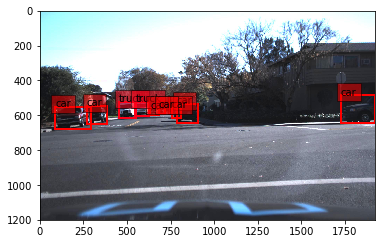

In [13]:
draw('object-detection-crowdai/1479498371963069978.jpg')


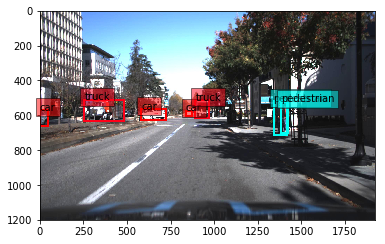

In [14]:
draw('object-detection-crowdai/1479503036282378933.jpg')

In [15]:
img = mpimg.imread('/data/datasets/udacity/object-detection-crowdai/1479498371963069978.jpg')
h, w, _ = img.shape
#coordinates of the object(s) in the image,eg: (x/img_width, y/img_height, (x+w)/img_width, (y+h)/img_height).
df.xmin = df.xmin / w
df.xmax = df.xmax / w

df.ymin = df.ymin / h
df.ymax = df.ymax / h

/home/carnd/anaconda3/envs/tf/lib/python3.5/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [16]:
lb = LabelBinarizer()
y = lb.fit_transform(df.label)
print(lb.classes_)

alex=lb.transform(['car', 'pedestrian', 'truck', 'car', 'pedestrian'])
print('alex',alex)

['car' 'pedestrian' 'truck']
alex [[1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]]


import pickle

gt_sample = pickle.load(open('/home/a/WA/delete-me/single_shot_multibox_detector/pikls/gt_pascal.pkl', 'rb'))
gt_sample

In [17]:
# Creating the picle hotcoded datasets with background
dataset = dict()
for idx, row in df.iterrows():
    coords = [row.xmin, row.ymin, row.xmax, row.ymax]
    label_encoded = lb.transform([row.label]).ravel()
    label_encoded = np.insert(label_encoded,0, 0, axis=0)
    #print('label_encoded',label_encoded)
    val = np.array([np.hstack((coords, label_encoded))])
    
    current = dataset.get(row.frame)
    if current is None:
        dataset[row.frame] = val
    else:
        dataset[row.frame] = np.vstack((current, val))
#dataset

# Creating the picle hotcoded datasets without background
dataset = dict()
for idx, row in df.iterrows():
    coords = [row.xmin, row.ymin, row.xmax, row.ymax]
    label_encoded = lb.transform([row.label]).ravel()
    
    val = np.array([np.hstack((coords, label_encoded))])
    
    current = dataset.get(row.frame)
    if current is None:
        dataset[row.frame] = val
    else:
        dataset[row.frame] = np.vstack((current, val))
dataset

In [18]:
#gt = pickle.load(open('/home/a/WA/delete-me/single_shot_multibox_detector/pikls/ground-truth.pkl', 'rb'))


#pickle.dump(dataset, open("/home/a/WA/delete-me/single_shot_multibox_detector/pikls/ground-truth.pkl", "wb"))

In [19]:
import numpy as np
from random import shuffle

#from .utils import load_image
#from .utils import preprocess_images
#from .preprocessing import load_image
#from .preprocessing import preprocess_images
#from .boxes import assign_prior_boxes

class ImageGenerator(object):
    """ Image generator with saturation, brightness, lighting, contrast,
    horizontal flip and vertical flip transformations. It supports
    bounding boxes coordinates.

    TODO:
        - Finish preprocess_images method.
        - Add random crop method.
        - Finish support for not using bounding_boxes.
    """
    
    #change ground_truth_data to ground_truth_data
    def __init__(self, ground_truth_data, prior_boxes, num_classes,
                box_scale_factors,
                batch_size, image_size,
                train_keys, validation_keys, path_prefix=None,
                saturation_var=0.5,
                brightness_var=0.5,
                contrast_var=0.5,
                lighting_std=0.5,
                horizontal_flip_probability=0.5,
                vertical_flip_probability=0.5,
                do_crop=True,
                crop_area_range=[0.75, 1.0],
                aspect_ratio_range=[3./4., 4./3.]):

        self.ground_truth_data = ground_truth_data
        self.prior_boxes = prior_boxes
        self.num_classes = num_classes
        self.box_scale_factors = box_scale_factors
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.validation_keys = validation_keys
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.horizontal_flip_probability = horizontal_flip_probability
        self.vertical_flip_probability = vertical_flip_probability
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range

    def _gray_scale(self, image_array):
        return image_array.dot([0.299, 0.587, 0.114])

    def saturation(self, image_array):
        gray_scale = self._gray_scale(image_array)
        alpha = 2.0 * np.random.random() * self.brightness_var
        alpha = alpha + 1 - self.saturation_var
        image_array = alpha * image_array + (1 - alpha) * gray_scale[:, :, None]
        return np.clip(image_array, 0, 255)

    def brightness(self, image_array):
        alpha = 2 * np.random.random() * self.brightness_var
        alpha = alpha + 1 - self.saturation_var
        image_array = alpha * image_array
        return np.clip(image_array, 0, 255)

    def contrast(self, image_array):
        gray_scale = (self._gray_scale(image_array).mean() *
                        np.ones_like(image_array))
        alpha = 2 * np.random.random() * self.contrast_var
        alpha = alpha + 1 - self.contrast_var
        image_array = image_array * alpha + (1 - alpha) * gray_scale
        return np.clip(image_array, 0, 255)

    def lighting(self, image_array):
        covariance_matrix = np.cov(image_array.reshape(-1,3) /
                                    255.0, rowvar=False)
        eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigen_vectors.dot(eigen_values * noise) * 255
        image_array = image_array + noise
        return np.clip(image_array, 0 , 255)

    def horizontal_flip(self, image_array, box_corners):
        if np.random.random() < self.horizontal_flip_probability:
            image_array = image_array[:, ::-1]
            box_corners[:, [0, 2]] = 1 - box_corners[:, [2, 0]]
        return image_array, box_corners

    def vertical_flip(self, image_array, box_corners):
        if (np.random.random() < self.vertical_flip_probability):
            image_array = image_array[::-1]
            box_corners[:, [1, 3]] = 1 - box_corners[:, [3, 1]]
        return image_array, box_corners

    def transform(self, image_array, box_corners):
        shuffle(self.color_jitter)
        for jitter in self.color_jitter:
            image_array = jitter(image_array)

        if self.lighting_std:
            image_array = self.lighting(image_array)

        if self.horizontal_flip_probability > 0:
            image_array, box_corners = self.horizontal_flip(image_array,
                                                            box_corners)

        if self.vertical_flip_probability > 0:
            image_array, box_corners = self.vertical_flip(image_array,
                                                            box_corners)

        return image_array, box_corners

    def flow(self, mode='train'):
            while True:
                if mode =='train':
                    #print('Train mode set')
                    shuffle(self.train_keys)
                    keys = self.train_keys
                elif mode == 'val' or  mode == 'demo':
                    #print('val/demo mode set')
                    shuffle(self.validation_keys)
                    keys = self.validation_keys
                else:
                    raise Exception('invalid mode: %s' % mode)

                inputs = []
                targets = []
                #print('number of keys',len(keys))
                for key in keys:
                     
                    image_path = self.path_prefix + key
                    #print('image_path', image_path)
                    image_array = load_image(image_path, self.image_size)
                    #print('image_array_before', image_array)
                    box_corners = self.ground_truth_data[key].copy()
                    
                    if mode == 'train' or mode == 'demo':
                        image_array, box_corners = self.transform(image_array,
                                                                box_corners)
                    #print('box_corners',box_corners)
                    box_corners = assign_prior_boxes(self.prior_boxes,
                                                    box_corners,
                                                    self.num_classes,
                                                    self.box_scale_factors)
                    #print('box_corners_with anchors',box_corners)
                    inputs.append(image_array)
                    #print('inputs', inputs)
                    targets.append(box_corners)
                    #print('targets', targets)
                    if len(targets) == self.batch_size:
                        inputs = np.asarray(inputs)
                        targets = np.asarray(targets)
                        if mode == 'train' or mode == 'val':
                            inputs = preprocess_images(inputs)
                            #print(self._wrap_in_dictionary(inputs, targets))
                            yield self._wrap_in_dictionary(inputs, targets)
                        if mode == 'demo':
                            yield self._wrap_in_dictionary(inputs, targets)
                        inputs = []
                        targets = []
                        #print('inputs',inputs)
                        #print('targets',targets)

    def _wrap_in_dictionary(self, image_array, targets):
        return [{'input_1':image_array},
                {'predictions':targets}]
 

In [20]:
gt = dataset
keys = sorted(gt.keys())
shuffle(keys)
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)
#ground_truth_data = gt
 
print('train_keys',len(train_keys))
print('val_keys',len(val_keys))

 

 

train_keys 17746
val_keys 4437


In [21]:
ground_truth_data = gt

train_keys, validation_keys = split_data(ground_truth_data, training_ratio=.8)

#print('ground_truth_data sample',ground_truth_data )
#print('train_keys', train_keys)
#print('validation_keys', len(validation_keys))

In [22]:
 
# instantiating model
from keras import metrics
model = SSD300(image_shape, num_classes, weights_path, frozen_layers)
multibox_loss = MultiboxLoss(num_classes, neg_pos_ratio=2.0).compute_loss
model.compile(optimizer, loss=multibox_loss, metrics=['acc'])#,metrics.mae, metrics.categorical_accuracy])




 

In [23]:
# setting parameters for data augmentation generator
batch_size = 1
prior_boxes = create_prior_boxes(model)
 
image_generator = ImageGenerator(ground_truth_data,
                                 prior_boxes,
                                 num_classes,
                                 box_scale_factors,
                                 batch_size,
                                 image_shape[0:2],
                                 train_keys, validation_keys,
                                 image_prefix,
                                 vertical_flip_probability=0,
                                 horizontal_flip_probability=0.5)


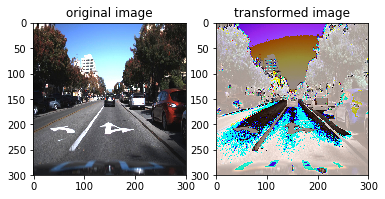

In [24]:
import glob
from utils.inference import predict
from utils.preprocessing import get_image_size
from utils.preprocessing import load_pil_image
from scipy.misc import imread
from utils.preprocessing import image_to_array
from utils.datasets import get_class_names
from utils.datasets import get_arg_to_class
from utils.preprocessing import load_image
from utils.visualizer import draw_image_boxes
from utils.boxes import assign_prior_boxes

import numpy as np
from utils.preprocessing import preprocess_images
from utils.boxes import decode_boxes
from utils.boxes import filter_boxes
from utils.preprocessing import resize_image_array
from utils.boxes import denormalize_box
from utils.boxes import apply_non_max_suppression
from utils.tf_boxes import apply_non_max_suppression
from utils.data_augmentation import ImageGenerator
from utils.preprocessing import load_image
from utils.visualizer import plot_images
from utils.train import split_data

#######################################################
## Testing generator

input_shape=(300, 300, 3)
generated_data = next(image_generator.flow(mode='val'))
generated_input = generated_data[0]['input_1']
#print('generated_data', generated_data)
generated_output = generated_data[1]['predictions']
generated_image = np.squeeze(generated_input[0]).astype('uint8')
validation_image_name = image_prefix + validation_keys[0]
original_image = load_image(validation_image_name, input_shape)
plot_images(original_image, generated_image)

#########################################################

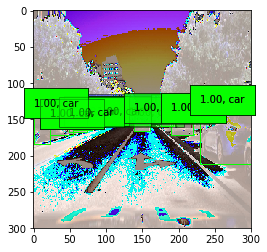

In [25]:
class_decoder={0: 'background', 1: 'car', 2: 'pedestrian', 2: 'truck'}
generated_encoded_boxes = np.squeeze(generated_output)
generated_boxes = decode_boxes(generated_encoded_boxes, prior_boxes,
                                                  box_scale_factors)
positive_mask = generated_boxes[:, 4] != 1
generated_positive_boxes = generated_boxes[positive_mask]
draw_image_boxes(generated_positive_boxes, generated_image, class_decoder)

In [26]:
# instantiating callbacks
learning_rate_schedule = LearningRateScheduler(scheduler)
model_names = (trained_models_filename)
model_checkpoint = ModelCheckpoint(model_names,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=False,
                                   save_weights_only=False)
model_tensorboard = TensorBoard(log_dir='./logs/200-epoch/udacity', 
                                         histogram_freq=10,
                                         batch_size = 8,
                                         write_graph=True,
                                         write_images=True,
                                          
                                         write_grads=True,
                                         embeddings_freq =5,
                                         embeddings_layer_names = 'conv3_3, conv4_3' 
                                 )


In [ ]:
# training model with real-time data augmentation
batch_size = 16
model.fit_generator(image_generator.flow(mode='train'),
                    steps_per_epoch=int(len(train_keys) / batch_size),
                    epochs = num_epochs, verbose = 1,
                    callbacks=[model_checkpoint, learning_rate_schedule, model_tensorboard],
                    validation_data=image_generator.flow(mode='val'),
                    validation_steps=int(len(validation_keys) / batch_size))

/home/carnd/anaconda3/envs/tf/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Summary name conv1_1/kernel:0 is illegal; using conv1_1/kernel_0 instead.
INFO:tensorflow:Summary name conv1_1/kernel:0_grad is illegal; using conv1_1/kernel_0_grad instead.
INFO:tensorflow:Summary name conv1_1/bias:0 is illegal; using conv1_1/bias_0 instead.
INFO:tensorflow:Summary name conv1_1/bias:0_grad is illegal; using conv1_1/bias_0_grad instead.
INFO:tensorflow:Summary name conv1_1/bias:0 is illegal; using conv1_1/bias_0 instead.
INFO:tensorflow:Summary name conv1_2/kernel:0 is illegal; using conv1_2/kernel_0 instead.
INFO:tensorflow:Summary name conv1_2/kernel:0_grad is illegal; using conv1_2/kernel_0_grad instead.
INFO:tensorflow:Summary name conv1_2/bias:0 is illegal; using conv1_2/bias_0 instead.
INFO:tensorflow:Summary name conv1_2/bias:0_grad is illegal; using conv1_2/bias_0_grad instead.
INFO:tensorflow:Summary name conv1_2/bias:0 is illegal; using conv1_2/bias_0 instead.
INFO:tensorflow:Summary name conv2_1/kernel:0 is illegal; using conv2_1/kernel_0 ins

INFO:tensorflow:Summary name conv7_1/bias:0_grad is illegal; using conv7_1/bias_0_grad instead.
INFO:tensorflow:Summary name conv7_1/bias:0 is illegal; using conv7_1/bias_0 instead.
INFO:tensorflow:Summary name conv7_2/kernel:0 is illegal; using conv7_2/kernel_0 instead.
INFO:tensorflow:Summary name conv7_2/kernel:0_grad is illegal; using conv7_2/kernel_0_grad instead.
INFO:tensorflow:Summary name conv7_2/bias:0 is illegal; using conv7_2/bias_0 instead.
INFO:tensorflow:Summary name conv7_2/bias:0_grad is illegal; using conv7_2/bias_0_grad instead.
INFO:tensorflow:Summary name conv7_2/bias:0 is illegal; using conv7_2/bias_0 instead.
INFO:tensorflow:Summary name conv8_1/kernel:0 is illegal; using conv8_1/kernel_0 instead.
INFO:tensorflow:Summary name conv8_1/kernel:0_grad is illegal; using conv8_1/kernel_0_grad instead.
INFO:tensorflow:Summary name conv8_1/kernel:0 is illegal; using conv8_1/kernel_0 instead.
INFO:tensorflow:Summary name conv8_1/bias:0 is illegal; using conv8_1/bias_0 ins

INFO:tensorflow:Summary name pool6_mbox_conf_flat_4/bias:0 is illegal; using pool6_mbox_conf_flat_4/bias_0 instead.
INFO:tensorflow:Summary name pool6_mbox_loc_flat/kernel:0 is illegal; using pool6_mbox_loc_flat/kernel_0 instead.
INFO:tensorflow:Summary name pool6_mbox_loc_flat/kernel:0_grad is illegal; using pool6_mbox_loc_flat/kernel_0_grad instead.
INFO:tensorflow:Summary name pool6_mbox_loc_flat/kernel:0 is illegal; using pool6_mbox_loc_flat/kernel_0 instead.
INFO:tensorflow:Summary name pool6_mbox_loc_flat/bias:0 is illegal; using pool6_mbox_loc_flat/bias_0 instead.
INFO:tensorflow:Summary name pool6_mbox_loc_flat/bias:0_grad is illegal; using pool6_mbox_loc_flat/bias_0_grad instead.
INFO:tensorflow:Summary name pool6_mbox_loc_flat/bias:0 is illegal; using pool6_mbox_loc_flat/bias_0 instead.
Epoch 1/150
1109/1109 [==============================] - 243s - loss: 1.9416 - acc: 0.1349 - val_loss: 1.8146 - val_acc: 0.0711
Epoch 2/150
1109/1109 [==============================] - 195s - 

1109/1109 [==============================] - 194s - loss: 1.5868 - acc: 0.0376 - val_loss: 1.7034 - val_acc: 0.0490
Epoch 26/150
1109/1109 [==============================] - 227s - loss: 1.5577 - acc: 0.0411 - val_loss: 1.6871 - val_acc: 0.0329
Epoch 27/150
1109/1109 [==============================] - 192s - loss: 1.5209 - acc: 0.0437 - val_loss: 1.7823 - val_acc: 0.0412
Epoch 28/150
1109/1109 [==============================] - 193s - loss: 1.5326 - acc: 0.0465 - val_loss: 1.6794 - val_acc: 0.0588
Epoch 29/150
1109/1109 [==============================] - 194s - loss: 1.5172 - acc: 0.0511 - val_loss: 1.7521 - val_acc: 0.0419
Epoch 30/150
1109/1109 [==============================] - 194s - loss: 1.5442 - acc: 0.0451 - val_loss: 1.7107 - val_acc: 0.0316
Epoch 31/150
1109/1109 [==============================] - 230s - loss: 1.5486 - acc: 0.0394 - val_loss: 1.5708 - val_acc: 0.0366
Epoch 32/150
1109/1109 [==============================] - 190s - loss: 1.5350 - acc: 0.0426 - val_loss: 1.7548